In [1]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import h5py
from time import time
from datetime import datetime
from IPython import display as display_IPython

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the MODELS

In [2]:
from collections import OrderedDict

class FCModel(nn.Module):
    def __init__(self, input_size, n_layers, neurons_per_layer, dropout_per_layer, h, w, use_relu_in_last=False): 
        # last layer number of neurons will be equal to the output size!
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.h=h
        self.w=w
        
        assert h*w==neurons_per_layer[-1]
        
        sequence=[(f'Linear0', nn.Linear(input_size, neurons_per_layer[0])), 
                      (f'ReLU0',nn.ReLU())]
        for i in range(1,n_layers):
            if dropout_per_layer[i]!=0:
                sequence.append((f'Dropout{i}', nn.Dropout(p=dropout_per_layer[i], inplace=False)))
            sequence.append((f'Linear{i}', nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i])))
            sequence.append((f'ReLU{i}', nn.ReLU()))
            
        if use_relu_in_last==False:
            sequence=sequence[:-1]
        self.network = nn.Sequential(OrderedDict( sequence ))

    def forward(self, x):
        x = x.view(-1, self.input_size) # [N_batch, input_size]
        return torch.reshape(self.network(x), (x.shape[0], self.h, self.w) ) # [N_batch, neurons_per_layer[-1]]


class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class FC_CNN_Model(nn.Module):
    def __init__(self, input_size, n_fc_layers, neurons_per_layer, h, w, 
                 unflatten_shape, n_cnn_layers, filter_size_per_layer,
                 channels_per_layer,
                 use_relu_in_last=False): 
        # last layer number of neurons will be equal to the output size!
        super(FC_CNN_Model, self).__init__()
        self.input_size = input_size
        self.h=h
        self.w=w
        
        assert unflatten_shape[0]*unflatten_shape[1]*unflatten_shape[2]==neurons_per_layer[-1]        
        
        sequence=[(f'Linear0', nn.Linear(input_size, neurons_per_layer[0])), 
                      (f'ReLU0',nn.ReLU())]
        #sequence.append((f'print', PrintLayer()))

        for i in range(1,n_fc_layers):
            sequence.append((f'Linear{i}', nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i])))
            sequence.append((f'ReLU{i}', nn.ReLU()))
            #sequence.append((f'print{i}', PrintLayer()))
        
        sequence.append((f'Unflatten', nn.Unflatten(dim=1, unflattened_size=unflatten_shape)))
        #sequence.append((f'print0', PrintLayer()))

        sequence.append((f'CNN0', nn.ConvTranspose2d(in_channels=unflatten_shape[0],
                                               out_channels=channels_per_layer[0], 
                                               kernel_size = filter_size_per_layer[0]))) 
        #sequence.append((f'print00', PrintLayer()))

        for i in range(1,n_cnn_layers):
            sequence.append((f'CNN{i}', nn.ConvTranspose2d(in_channels=channels_per_layer[i-1],
                                                    out_channels=channels_per_layer[i], 
                                                kernel_size = filter_size_per_layer[i])))
            sequence.append((f'ReLU{i+n_fc_layers}', nn.ReLU()))
            #sequence.append((f'print{i+n_fc_layers}', PrintLayer()))
            
        if use_relu_in_last==False:
            sequence=sequence[:-1]
        self.network = nn.Sequential(OrderedDict( sequence ))

    def forward(self, x):
        x = x.view(-1, self.input_size) # [N_batch, output_size]
        return torch.reshape(self.network(x), (x.shape[0], self.h, self.w) ) # [N_batch, neurons_per_layer[-1]]
    


In [3]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

# Instantiate a custom Dataset class

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Audio_Image_Dataset(Dataset):
    def __init__(self, h5f_full_path):
        self.h5f = h5py.File(f"{h5f_full_path}", 'r')
        self.im_shape = np.array(self.h5f[ "0_im" ]).shape
        self.aud_shape = np.array(self.h5f[ "0_aud" ]).shape
        self.num_samples = len(self.h5f)//2
        print(f"There are {self.num_samples} images and audios\nwith {self.im_shape} sized images\nand {self.aud_shape} sized audios")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.tensor(np.array(self.h5f[f"{idx}_im"]), dtype=torch.float32)
        audio = torch.tensor(np.array(self.h5f[f"{idx}_aud"]), dtype=torch.float32)
        return audio, image

In [5]:
batch_size = 100
partition = 0.95
path_to_h5f = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DATASETS_DEPTH_IMAGE_ECHO_RECORDINGS/Dataset_Day1/Dataset.h5"

full_dataset = Audio_Image_Dataset( path_to_h5f )
train_size = int(partition * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
print(f"Train loader has {len(train_loader)*train_loader.batch_size}\nTest loader has {len(val_loader)*val_loader.batch_size}")

There are 1023 images and audios
with (57, 68) sized images
and (1027,) sized audios
Train loader has 1000
Test loader has 100


# Train and Validation Loops

In [6]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate_epoch(criterion, model, dataloader): 
    val_loss = 0

    model.eval() # disable the dropout, among others

    for batch_idx, (data, target) in enumerate(dataloader):  
        data, target = data.to(device), target.to(device)
        prediction = model(data)
        target = target.view(prediction.shape)
        loss = criterion(prediction, target)
        val_loss += loss.item()             

    val_loss /= len(dataloader)
    print(f'\nValidation set: Average loss: {val_loss:.4f} \n')
    return val_loss


def train_epoch(epoch, criterion, model, optimizer, dataloader, print_loss_every_batches=20,
                optimizer_step_every_batches=1):
    
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()
    #t = time()
    for batch_idx, (data, target) in enumerate(dataloader):  
        data, target = data.to(device), target.to(device)
        prediction = model(data) # data is [batch_size, embedding_dim]
        loss = criterion(prediction, target)
        loss.backward()
        
        if batch_idx % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if batch_idx % print_loss_every_batches == print_loss_every_batches-1:
            print(f'Train Epoch: {epoch} [{(batch_idx+1) * len(data)}/{len(dataloader)*dataloader.batch_size} ({100*(batch_idx+1)*len(data) / (len(dataloader)*dataloader.batch_size):.0f}%)]\t Loss: {loss.item():.6f}')
            
        total_loss += loss.item()

    return total_loss / len(dataloader)

## Full training loop

In [7]:
def full_training_loop(model, criterion, optimizer, train_loader, test_loader, epochs=10,
                       print_loss_every_batches=20, validate_every_epochs=2, optimizer_step_every_batches=1,
                      image_path=None, save_model_every_epochs=1, model_path=None, best_model_path=None):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, criterion, model, optimizer, train_loader,
                                 print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches
                                )
        if epoch%validate_every_epochs==0 and epoch!=0:
            val_loss = validate_epoch(criterion, model, test_loader)
        else:
            try:
                val_loss = losses["val"][-1]
            except:
                val_loss = train_loss
        if epoch and train_loss<=min(losses["train"]) and best_model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, best_model_path)
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)        
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
        plt.yscale('log')
        plt.legend()
        if image_path is not None:
            plt.savefig(image_path)
            plt.clf()
        else:
            display_IPython.clear_output(wait=True)
            plt.pause(0.001)
            plt.show()
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return losses

# Fix the Hyperparameters and Initialize the Model and the Optimizer

In [8]:
# Fully Connected
input_size = full_dataset.aud_shape[0]
h = full_dataset.im_shape[0]
w = full_dataset.im_shape[1]

neurons_per_layer = [input_size, input_size//2, input_size//2, input_size, input_size*2, h*w]
dropout_per_layer = [0.1, 0.1,0.1, 0.1, 0.1, 0.1]
exp_name = f"FC_{neurons_per_layer}"
n_layers = len(neurons_per_layer)
use_relu_in_last = True

# FC + Convolutional
input_size= full_dataset.aud_shape[0]
neurons_per_layer=[input_size//2, input_size//5, 100]
n_fc_layers=len(neurons_per_layer)
h=full_dataset.im_shape[0]
w=full_dataset.im_shape[1]
unflatten_shape=(1, 10,10)
filter_size_per_layer=[[11,11], [11,11], [11,11], [11,11], [8,19]]
channels_per_layer=[10, 10, 8, 6, 1]
n_cnn_layers=len(filter_size_per_layer)
use_relu_in_last=False
exp_name = f"FC_CNN_fc_ns{neurons_per_layer}_ker_siz{filter_size_per_layer}_chans_l{channels_per_layer}"


# other params

total_epochs = 1000
validate_every_epochs = 2
optimizer_step_every_batches = 1
save_model_every_epochs = 2
torch.manual_seed(678)



In [9]:
#model = FCModel(input_size=input_size, n_layers=n_layers, neurons_per_layer=neurons_per_layer,
#                dropout_per_layer=dropout_per_layer,
#                h=h, w=w, use_relu_in_last=use_relu_in_last)

model = FC_CNN_Model(input_size=input_size, n_fc_layers=n_fc_layers, neurons_per_layer=neurons_per_layer,
                     h=h, w=w, unflatten_shape=unflatten_shape, n_cnn_layers=n_cnn_layers,
                     filter_size_per_layer=filter_size_per_layer, channels_per_layer=channels_per_layer,
                 use_relu_in_last=use_relu_in_last)

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
out_path = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DEEP_LEARNING_LAB/Networks/"
#check_file=".pt"
#checkpoint = torch.load(f"{out_path}/{check_file}")

# move model to gpu if available
model.to(device)

#model.load_state_dict(checkpoint['model'])


# Initialize the weights of the model! Default initialization might already be fine!

# we can use a MSE loss for the regression task we have in hands
criterion = nn.MSELoss()

# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.99, 0.9999), 
                             eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer.load_state_dict(checkpoint['optimizer'])

Number of parameters 683079


# Run the Training

In [10]:
%%time
losses = full_training_loop(model, criterion, optimizer, train_loader, val_loader, 
                    epochs=total_epochs, print_loss_every_batches=9,
                            validate_every_epochs=validate_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches,
                           image_path=out_path+ f"/Training_Loss_{datetime.now()}_{exp_name}.png",
                           save_model_every_epochs=save_model_every_epochs, 
                            model_path=out_path+f"/Model_and_Optimizer_{datetime.now()}_{exp_name}.pt",
                            best_model_path=out_path+f"/BEST_Model_and_Optimizer_{datetime.now()}_{exp_name}.pt"
                           )
# Execute the training and validation

Train Epoch: 0 [900/1000 (90%)]	 Loss: 7667.944824
Train Epoch: 1 [900/1000 (90%)]	 Loss: 6918.984863
Train Epoch: 2 [900/1000 (90%)]	 Loss: 8216.119141

Validation set: Average loss: 8173.4048 

Train Epoch: 3 [900/1000 (90%)]	 Loss: 8098.928223
Train Epoch: 4 [900/1000 (90%)]	 Loss: 7681.933105

Validation set: Average loss: 8170.2695 

Train Epoch: 5 [900/1000 (90%)]	 Loss: 6307.886719
Train Epoch: 6 [900/1000 (90%)]	 Loss: 7464.244141

Validation set: Average loss: 8110.2168 

Train Epoch: 7 [900/1000 (90%)]	 Loss: 7420.385742
Train Epoch: 8 [900/1000 (90%)]	 Loss: 6368.363281

Validation set: Average loss: 7556.2954 

Train Epoch: 9 [900/1000 (90%)]	 Loss: 6152.242676
Train Epoch: 10 [900/1000 (90%)]	 Loss: 6738.358398

Validation set: Average loss: 7181.4595 

Train Epoch: 11 [900/1000 (90%)]	 Loss: 6207.904785
Train Epoch: 12 [900/1000 (90%)]	 Loss: 6921.783691

Validation set: Average loss: 6969.3481 

Train Epoch: 13 [900/1000 (90%)]	 Loss: 6184.682617
Train Epoch: 14 [900/100


Validation set: Average loss: 2997.1765 

Train Epoch: 113 [900/1000 (90%)]	 Loss: 1306.373901
Train Epoch: 114 [900/1000 (90%)]	 Loss: 1473.903076

Validation set: Average loss: 2991.6477 

Train Epoch: 115 [900/1000 (90%)]	 Loss: 1247.267212
Train Epoch: 116 [900/1000 (90%)]	 Loss: 1635.965820

Validation set: Average loss: 2975.5186 

Train Epoch: 117 [900/1000 (90%)]	 Loss: 1334.757446
Train Epoch: 118 [900/1000 (90%)]	 Loss: 1423.791626

Validation set: Average loss: 2991.5425 

Train Epoch: 119 [900/1000 (90%)]	 Loss: 1244.393433
Train Epoch: 120 [900/1000 (90%)]	 Loss: 1364.492432

Validation set: Average loss: 2948.1890 

Train Epoch: 121 [900/1000 (90%)]	 Loss: 1244.836914
Train Epoch: 122 [900/1000 (90%)]	 Loss: 1505.104614

Validation set: Average loss: 2983.6672 

Train Epoch: 123 [900/1000 (90%)]	 Loss: 1273.411377
Train Epoch: 124 [900/1000 (90%)]	 Loss: 1232.464722

Validation set: Average loss: 2954.2444 

Train Epoch: 125 [900/1000 (90%)]	 Loss: 1150.075562
Train Epoc

Train Epoch: 224 [900/1000 (90%)]	 Loss: 788.333618

Validation set: Average loss: 2962.1487 

Train Epoch: 225 [900/1000 (90%)]	 Loss: 745.825012
Train Epoch: 226 [900/1000 (90%)]	 Loss: 649.670715

Validation set: Average loss: 2973.6106 

Train Epoch: 227 [900/1000 (90%)]	 Loss: 787.687561
Train Epoch: 228 [900/1000 (90%)]	 Loss: 738.963440

Validation set: Average loss: 2933.4158 

Train Epoch: 229 [900/1000 (90%)]	 Loss: 658.490112
Train Epoch: 230 [900/1000 (90%)]	 Loss: 777.178162

Validation set: Average loss: 2882.0007 

Train Epoch: 231 [900/1000 (90%)]	 Loss: 677.224731
Train Epoch: 232 [900/1000 (90%)]	 Loss: 672.555542

Validation set: Average loss: 2950.9873 

Train Epoch: 233 [900/1000 (90%)]	 Loss: 712.304077
Train Epoch: 234 [900/1000 (90%)]	 Loss: 748.602722

Validation set: Average loss: 2973.2178 

Train Epoch: 235 [900/1000 (90%)]	 Loss: 589.500305
Train Epoch: 236 [900/1000 (90%)]	 Loss: 673.537903

Validation set: Average loss: 2919.1523 

Train Epoch: 237 [900/1

Train Epoch: 336 [900/1000 (90%)]	 Loss: 508.497040

Validation set: Average loss: 3133.8472 

Train Epoch: 337 [900/1000 (90%)]	 Loss: 533.561768
Train Epoch: 338 [900/1000 (90%)]	 Loss: 468.051849

Validation set: Average loss: 3186.2588 

Train Epoch: 339 [900/1000 (90%)]	 Loss: 504.168976
Train Epoch: 340 [900/1000 (90%)]	 Loss: 477.750153

Validation set: Average loss: 3178.0042 

Train Epoch: 341 [900/1000 (90%)]	 Loss: 470.844666
Train Epoch: 342 [900/1000 (90%)]	 Loss: 558.893921

Validation set: Average loss: 3170.4678 

Train Epoch: 343 [900/1000 (90%)]	 Loss: 511.994049
Train Epoch: 344 [900/1000 (90%)]	 Loss: 539.134583

Validation set: Average loss: 3160.9446 

Train Epoch: 345 [900/1000 (90%)]	 Loss: 537.583435
Train Epoch: 346 [900/1000 (90%)]	 Loss: 500.364746

Validation set: Average loss: 3133.3840 

Train Epoch: 347 [900/1000 (90%)]	 Loss: 468.960327
Train Epoch: 348 [900/1000 (90%)]	 Loss: 558.301880

Validation set: Average loss: 3171.6028 

Train Epoch: 349 [900/1

Train Epoch: 448 [900/1000 (90%)]	 Loss: 406.762604

Validation set: Average loss: 3164.1650 

Train Epoch: 449 [900/1000 (90%)]	 Loss: 428.752197
Train Epoch: 450 [900/1000 (90%)]	 Loss: 417.905304

Validation set: Average loss: 3202.4424 

Train Epoch: 451 [900/1000 (90%)]	 Loss: 389.015137
Train Epoch: 452 [900/1000 (90%)]	 Loss: 396.670898

Validation set: Average loss: 3193.8474 

Train Epoch: 453 [900/1000 (90%)]	 Loss: 427.704315
Train Epoch: 454 [900/1000 (90%)]	 Loss: 440.066010

Validation set: Average loss: 3217.2053 

Train Epoch: 455 [900/1000 (90%)]	 Loss: 372.905701
Train Epoch: 456 [900/1000 (90%)]	 Loss: 429.943848

Validation set: Average loss: 3209.9656 

Train Epoch: 457 [900/1000 (90%)]	 Loss: 382.486755
Train Epoch: 458 [900/1000 (90%)]	 Loss: 452.294312

Validation set: Average loss: 3216.6064 

Train Epoch: 459 [900/1000 (90%)]	 Loss: 395.379364
Train Epoch: 460 [900/1000 (90%)]	 Loss: 400.872406

Validation set: Average loss: 3198.3135 

Train Epoch: 461 [900/1

Train Epoch: 560 [900/1000 (90%)]	 Loss: 353.461121

Validation set: Average loss: 3154.5339 

Train Epoch: 561 [900/1000 (90%)]	 Loss: 419.892914
Train Epoch: 562 [900/1000 (90%)]	 Loss: 321.707184

Validation set: Average loss: 3205.1179 

Train Epoch: 563 [900/1000 (90%)]	 Loss: 352.804443
Train Epoch: 564 [900/1000 (90%)]	 Loss: 384.002594

Validation set: Average loss: 3222.7146 

Train Epoch: 565 [900/1000 (90%)]	 Loss: 351.589539
Train Epoch: 566 [900/1000 (90%)]	 Loss: 348.940460

Validation set: Average loss: 3206.6479 

Train Epoch: 567 [900/1000 (90%)]	 Loss: 360.515778
Train Epoch: 568 [900/1000 (90%)]	 Loss: 339.913544

Validation set: Average loss: 3197.6128 

Train Epoch: 569 [900/1000 (90%)]	 Loss: 319.204590
Train Epoch: 570 [900/1000 (90%)]	 Loss: 351.405853

Validation set: Average loss: 3239.6963 

Train Epoch: 571 [900/1000 (90%)]	 Loss: 306.527802
Train Epoch: 572 [900/1000 (90%)]	 Loss: 331.056030

Validation set: Average loss: 3238.5508 

Train Epoch: 573 [900/1

Train Epoch: 672 [900/1000 (90%)]	 Loss: 305.119629

Validation set: Average loss: 3278.8184 

Train Epoch: 673 [900/1000 (90%)]	 Loss: 348.567291
Train Epoch: 674 [900/1000 (90%)]	 Loss: 333.329193

Validation set: Average loss: 3288.7754 

Train Epoch: 675 [900/1000 (90%)]	 Loss: 354.727539
Train Epoch: 676 [900/1000 (90%)]	 Loss: 337.060120

Validation set: Average loss: 3246.3184 

Train Epoch: 677 [900/1000 (90%)]	 Loss: 307.142334
Train Epoch: 678 [900/1000 (90%)]	 Loss: 324.590118

Validation set: Average loss: 3279.2864 

Train Epoch: 679 [900/1000 (90%)]	 Loss: 337.261841
Train Epoch: 680 [900/1000 (90%)]	 Loss: 330.624420

Validation set: Average loss: 3301.8730 

Train Epoch: 681 [900/1000 (90%)]	 Loss: 314.524658
Train Epoch: 682 [900/1000 (90%)]	 Loss: 311.215149

Validation set: Average loss: 3293.2991 

Train Epoch: 683 [900/1000 (90%)]	 Loss: 322.339935
Train Epoch: 684 [900/1000 (90%)]	 Loss: 275.679413

Validation set: Average loss: 3318.0649 

Train Epoch: 685 [900/1

Train Epoch: 784 [900/1000 (90%)]	 Loss: 260.875549

Validation set: Average loss: 3299.4121 

Train Epoch: 785 [900/1000 (90%)]	 Loss: 286.940979
Train Epoch: 786 [900/1000 (90%)]	 Loss: 294.947266

Validation set: Average loss: 3316.7490 

Train Epoch: 787 [900/1000 (90%)]	 Loss: 311.563049
Train Epoch: 788 [900/1000 (90%)]	 Loss: 349.889679

Validation set: Average loss: 3316.1873 

Train Epoch: 789 [900/1000 (90%)]	 Loss: 320.106995
Train Epoch: 790 [900/1000 (90%)]	 Loss: 267.081635

Validation set: Average loss: 3262.3037 

Train Epoch: 791 [900/1000 (90%)]	 Loss: 280.839569
Train Epoch: 792 [900/1000 (90%)]	 Loss: 280.652679

Validation set: Average loss: 3288.8936 

Train Epoch: 793 [900/1000 (90%)]	 Loss: 303.152649
Train Epoch: 794 [900/1000 (90%)]	 Loss: 358.898682

Validation set: Average loss: 3283.7595 

Train Epoch: 795 [900/1000 (90%)]	 Loss: 305.417816
Train Epoch: 796 [900/1000 (90%)]	 Loss: 311.986420

Validation set: Average loss: 3282.3770 

Train Epoch: 797 [900/1

Train Epoch: 896 [900/1000 (90%)]	 Loss: 258.002930

Validation set: Average loss: 3355.0276 

Train Epoch: 897 [900/1000 (90%)]	 Loss: 273.376434
Train Epoch: 898 [900/1000 (90%)]	 Loss: 277.630096

Validation set: Average loss: 3364.6653 

Train Epoch: 899 [900/1000 (90%)]	 Loss: 271.604645
Train Epoch: 900 [900/1000 (90%)]	 Loss: 260.476776

Validation set: Average loss: 3358.4905 

Train Epoch: 901 [900/1000 (90%)]	 Loss: 236.531799
Train Epoch: 902 [900/1000 (90%)]	 Loss: 243.094528

Validation set: Average loss: 3347.4624 

Train Epoch: 903 [900/1000 (90%)]	 Loss: 264.209412
Train Epoch: 904 [900/1000 (90%)]	 Loss: 289.053131

Validation set: Average loss: 3374.3257 

Train Epoch: 905 [900/1000 (90%)]	 Loss: 228.014572
Train Epoch: 906 [900/1000 (90%)]	 Loss: 306.818451

Validation set: Average loss: 3383.3250 

Train Epoch: 907 [900/1000 (90%)]	 Loss: 283.062866
Train Epoch: 908 [900/1000 (90%)]	 Loss: 228.095245

Validation set: Average loss: 3358.1272 

Train Epoch: 909 [900/1

<Figure size 432x288 with 0 Axes>

# Inference

In [9]:
# Fully Connected
input_size = full_dataset.aud_shape[0]
h = full_dataset.im_shape[0]
w = full_dataset.im_shape[1]

neurons_per_layer = [input_size//10, input_size//20, input_size//5, input_size//2, h*w]
dropout_per_layer = [0.2, 0.2,0.2, 0, 0, 0.2]
n_layers = len(neurons_per_layer)
use_relu_in_last = True
exp_name = f"FC_{neurons_per_layer}"


# FC + Convolutional
input_size= full_dataset.aud_shape[0]
neurons_per_layer=[input_size//2, input_size//5, 100]
n_fc_layers=len(neurons_per_layer)
h=full_dataset.im_shape[0]
w=full_dataset.im_shape[1]
unflatten_shape=(1, 10,10)
filter_size_per_layer=[[11,11], [11,11], [11,11], [11,11], [8,19]]
channels_per_layer=[10, 10, 8, 6, 1]
n_cnn_layers=len(filter_size_per_layer)
use_relu_in_last=False
exp_name = f"FC_CNN_fc_ns{neurons_per_layer}_ker_siz{filter_size_per_layer}_chans_l{channels_per_layer}"



in_path = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DEEP_LEARNING_LAB/Networks/"



#model = FCModel(input_size=input_size, n_layers=n_layers, neurons_per_layer=neurons_per_layer,
#                dropout_per_layer=dropout_per_layer,
#                h=h, w=w, use_relu_in_last=use_relu_in_last)

model = FC_CNN_Model(input_size=input_size, n_fc_layers=n_fc_layers, neurons_per_layer=neurons_per_layer,
                     h=h, w=w, unflatten_shape=unflatten_shape, n_cnn_layers=n_cnn_layers,
                     filter_size_per_layer=filter_size_per_layer, channels_per_layer=channels_per_layer,
                 use_relu_in_last=use_relu_in_last)

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
out_path = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DEEP_LEARNING_LAB/Networks/"
check_file=f"Model_and_Optimizer_2022-05-14 19:27:39.732530_FC_CNN_fc_ns[513, 205, 100]_ker_siz[[11, 11], [11, 11], [11, 11], [11, 11], [8, 19]]_chans_l[10, 10, 8, 6, 1].pt"
checkpoint = torch.load(f"{in_path}/{check_file}")

model.eval() # disable the dropout, among others

# move model to gpu if available
model.to(device)

Number of parameters 683079


FC_CNN_Model(
  (network): Sequential(
    (Linear0): Linear(in_features=1027, out_features=513, bias=True)
    (ReLU0): ReLU()
    (Linear1): Linear(in_features=513, out_features=205, bias=True)
    (ReLU1): ReLU()
    (Linear2): Linear(in_features=205, out_features=100, bias=True)
    (ReLU2): ReLU()
    (Unflatten): Unflatten(dim=1, unflattened_size=(1, 10, 10))
    (CNN0): ConvTranspose2d(1, 10, kernel_size=(11, 11), stride=(1, 1))
    (CNN1): ConvTranspose2d(10, 10, kernel_size=(11, 11), stride=(1, 1))
    (ReLU4): ReLU()
    (CNN2): ConvTranspose2d(10, 8, kernel_size=(11, 11), stride=(1, 1))
    (ReLU5): ReLU()
    (CNN3): ConvTranspose2d(8, 6, kernel_size=(11, 11), stride=(1, 1))
    (ReLU6): ReLU()
    (CNN4): ConvTranspose2d(6, 1, kernel_size=(8, 19), stride=(1, 1))
  )
)



Batch 0 ###############
pene


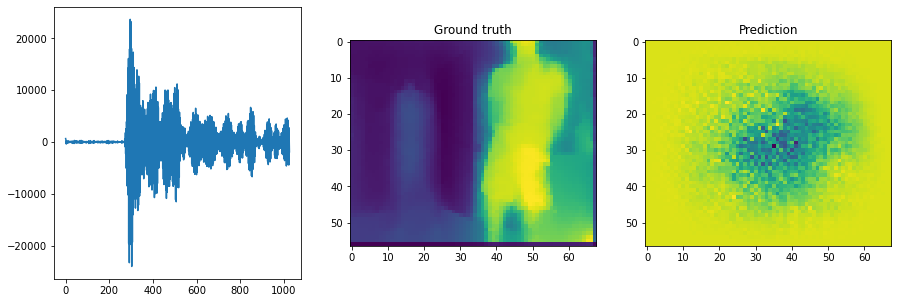

pene


<Figure size 432x288 with 0 Axes>

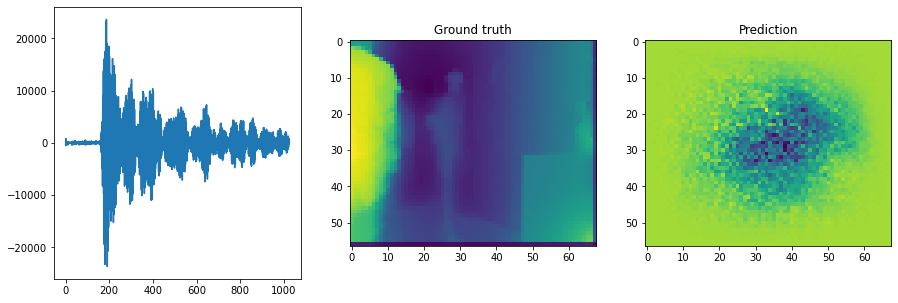

pene


<Figure size 432x288 with 0 Axes>

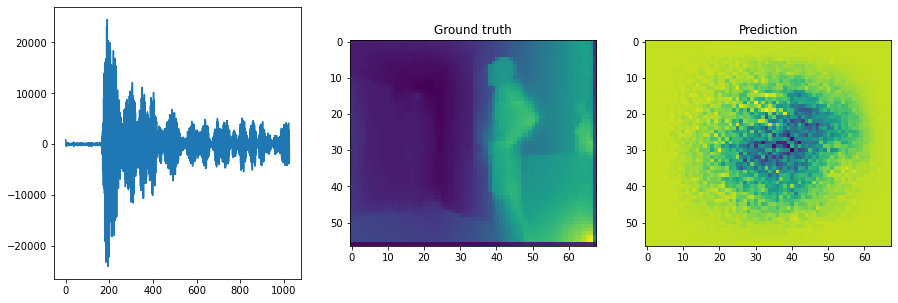

pene


<Figure size 432x288 with 0 Axes>

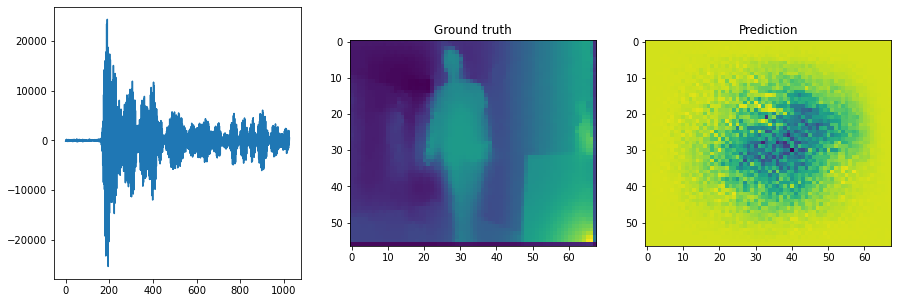

pene


<Figure size 432x288 with 0 Axes>

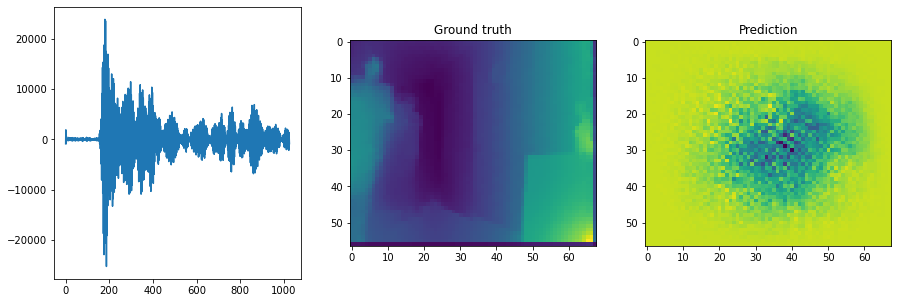

pene


<Figure size 432x288 with 0 Axes>

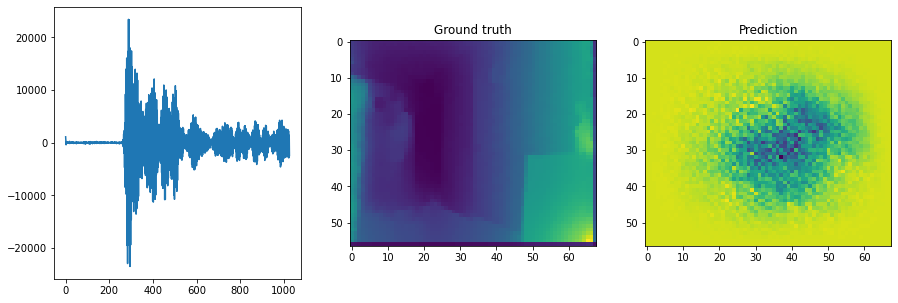

pene


<Figure size 432x288 with 0 Axes>

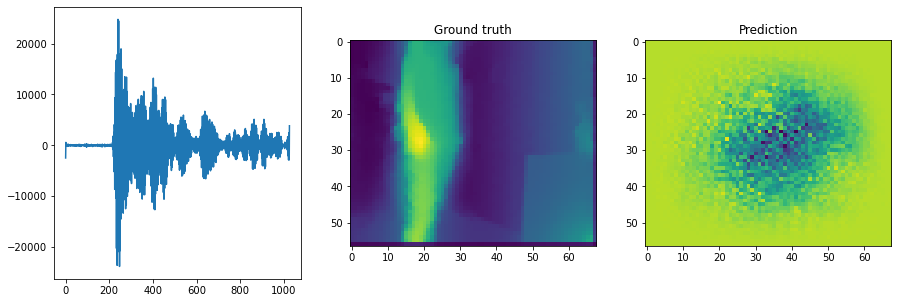

pene


<Figure size 432x288 with 0 Axes>

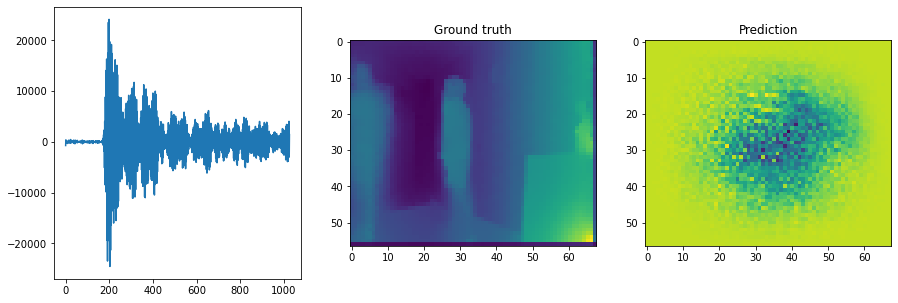

pene


<Figure size 432x288 with 0 Axes>

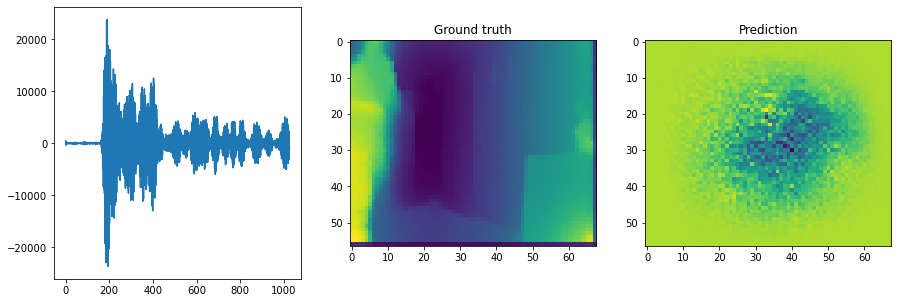

pene


<Figure size 432x288 with 0 Axes>

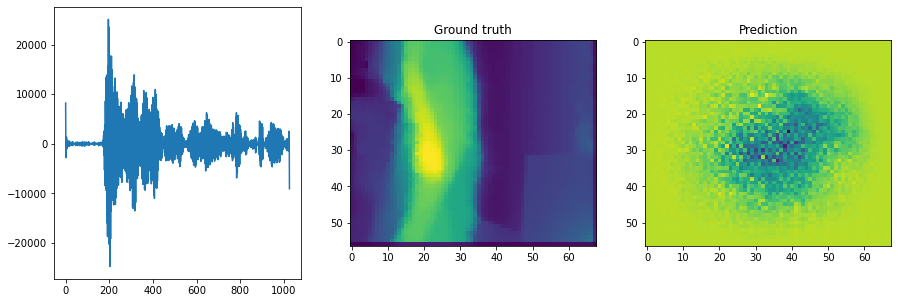

pene


<Figure size 432x288 with 0 Axes>

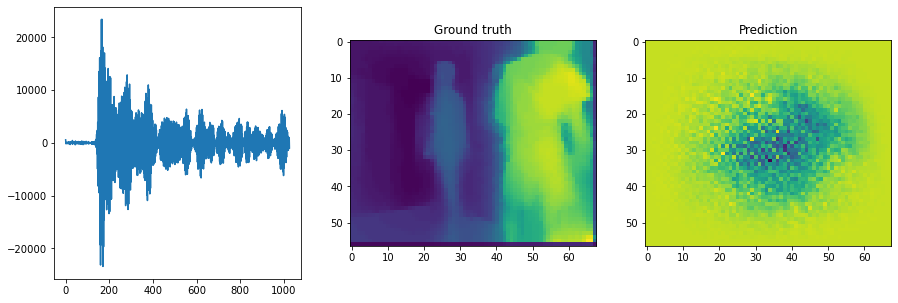

pene


<Figure size 432x288 with 0 Axes>

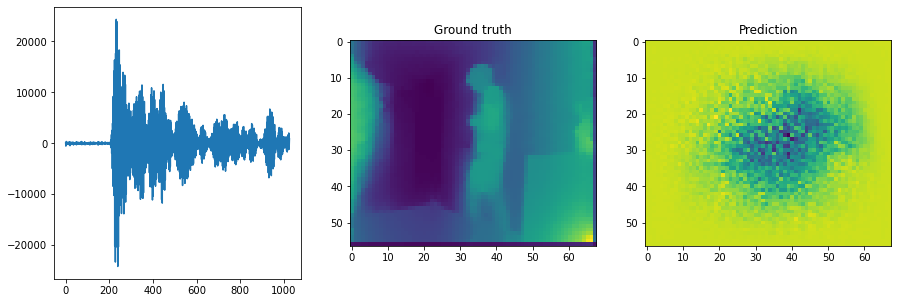

pene


<Figure size 432x288 with 0 Axes>

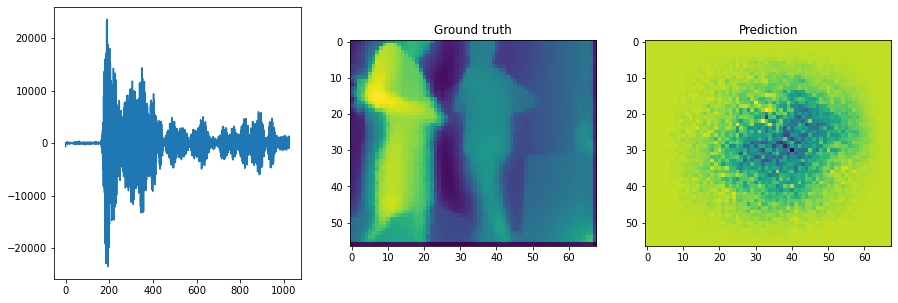

pene


<Figure size 432x288 with 0 Axes>

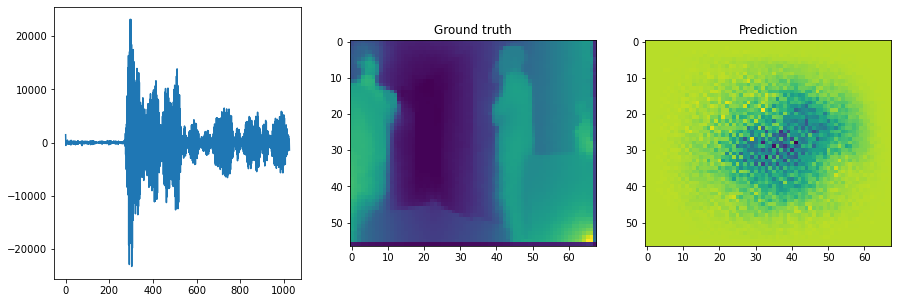

pene


<Figure size 432x288 with 0 Axes>

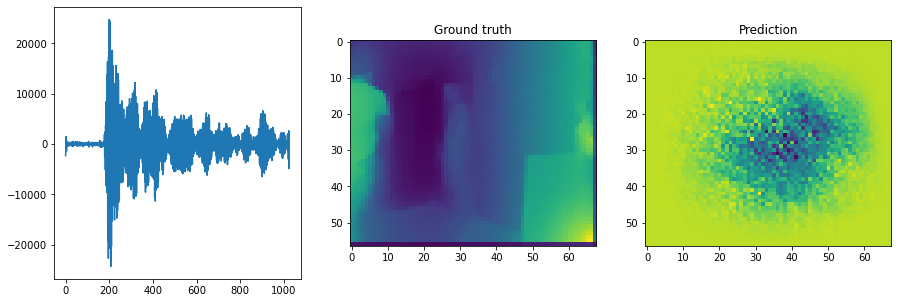

pene


<Figure size 432x288 with 0 Axes>

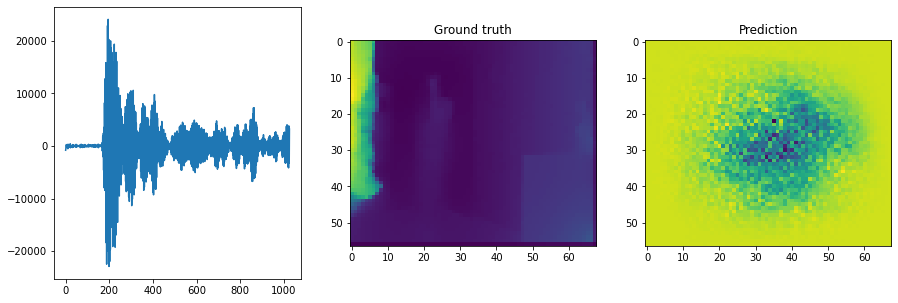

pene


<Figure size 432x288 with 0 Axes>

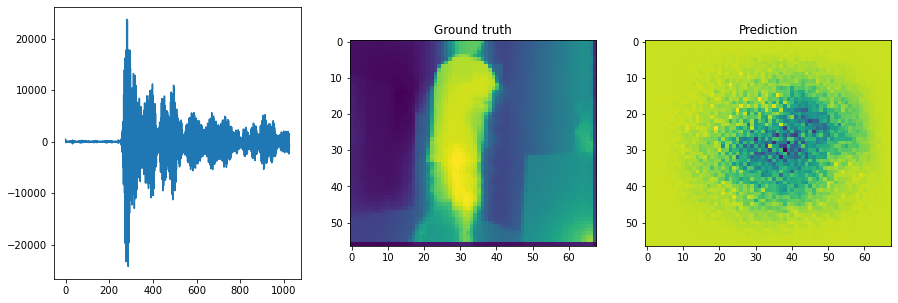

pene


<Figure size 432x288 with 0 Axes>

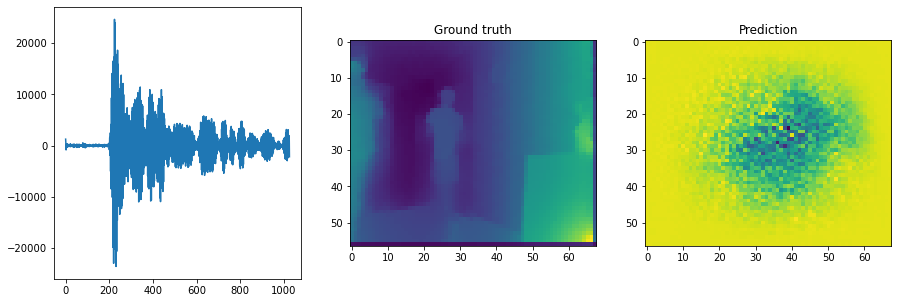

pene


<Figure size 432x288 with 0 Axes>

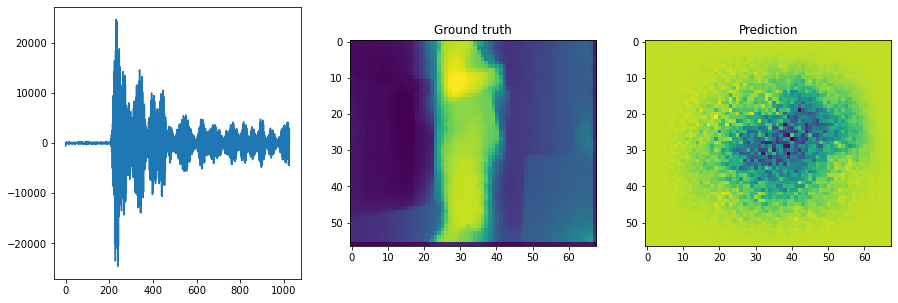

pene


<Figure size 432x288 with 0 Axes>

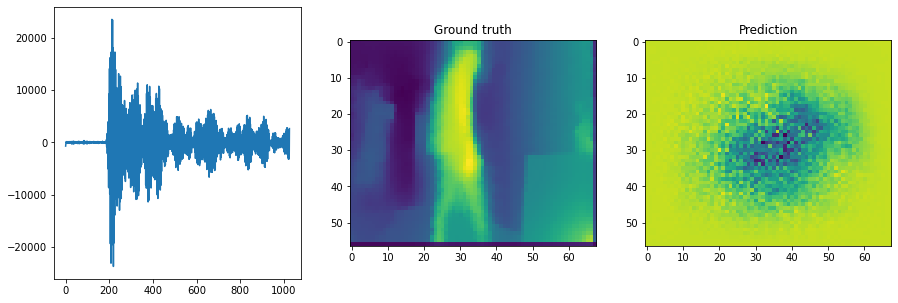

pene


<Figure size 432x288 with 0 Axes>

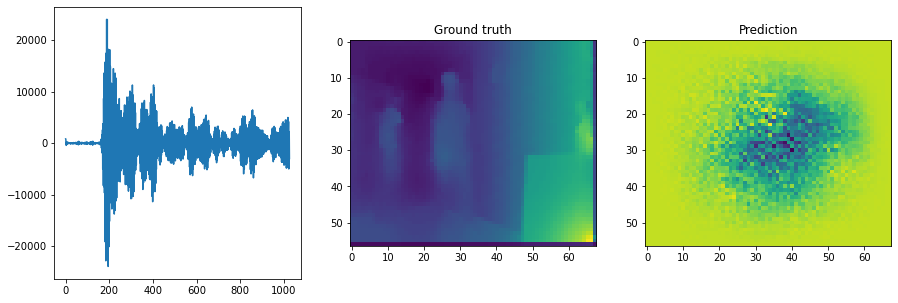

pene


<Figure size 432x288 with 0 Axes>

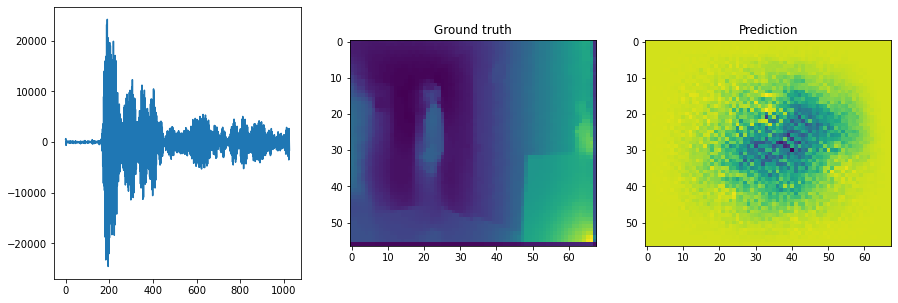

pene


<Figure size 432x288 with 0 Axes>

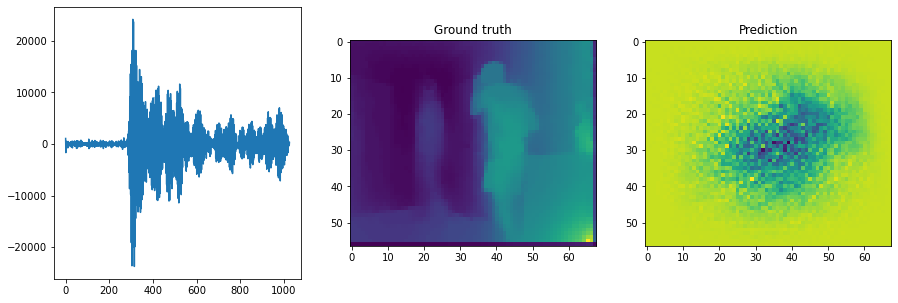

pene


<Figure size 432x288 with 0 Axes>

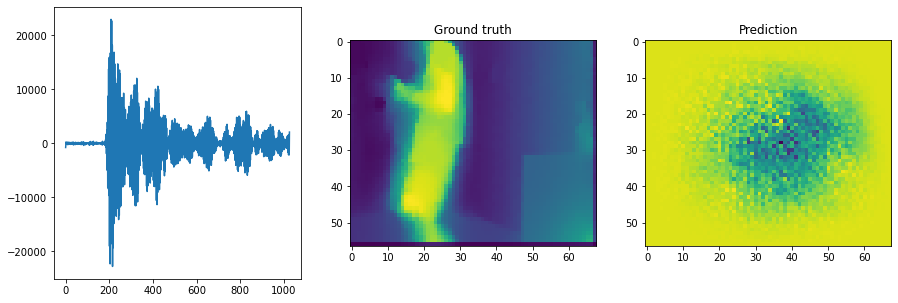

pene


<Figure size 432x288 with 0 Axes>

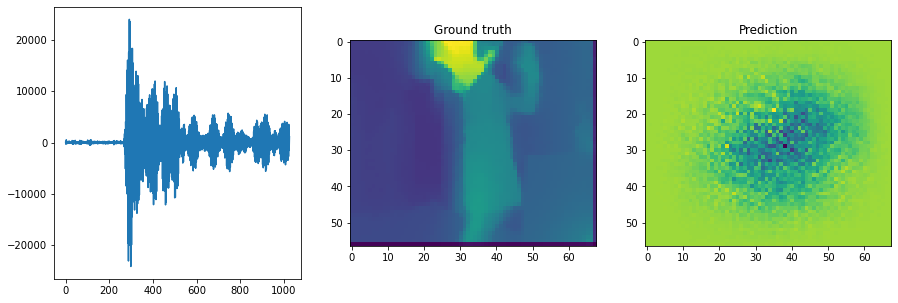

pene


<Figure size 432x288 with 0 Axes>

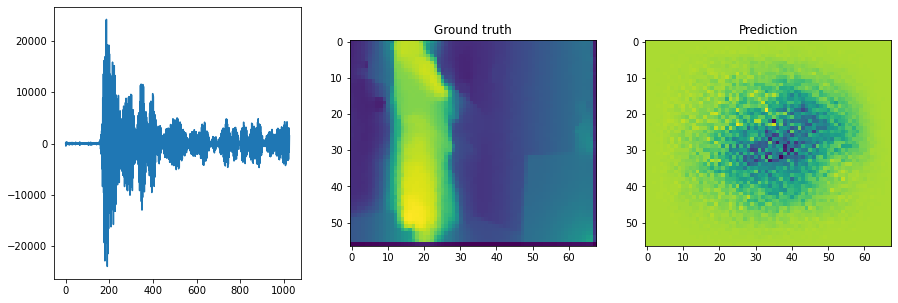

pene


<Figure size 432x288 with 0 Axes>

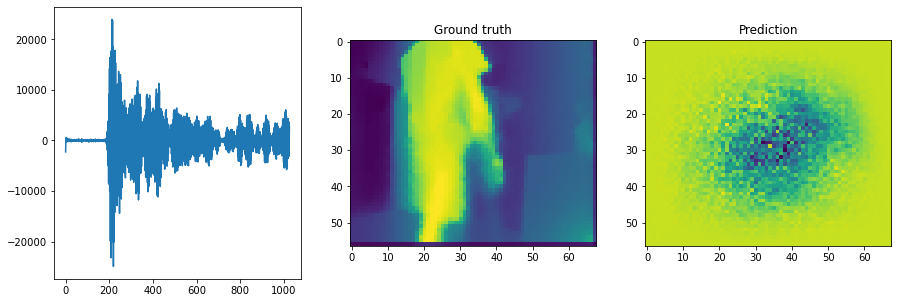

pene


<Figure size 432x288 with 0 Axes>

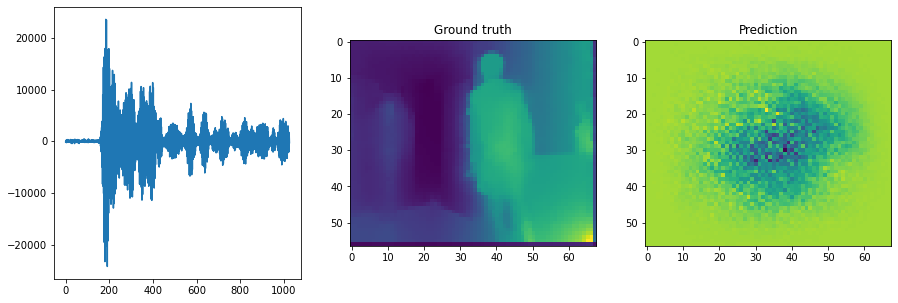

pene


<Figure size 432x288 with 0 Axes>

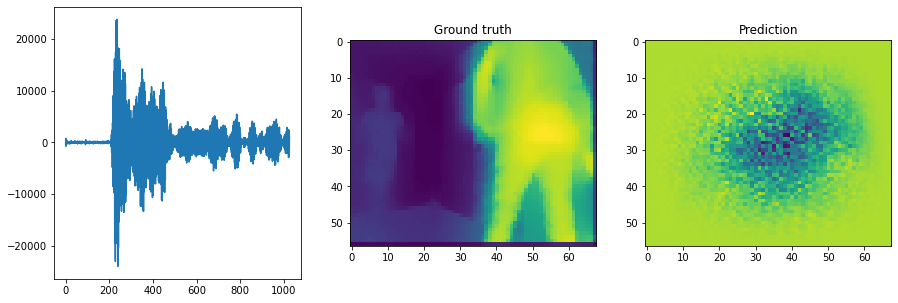

pene


<Figure size 432x288 with 0 Axes>

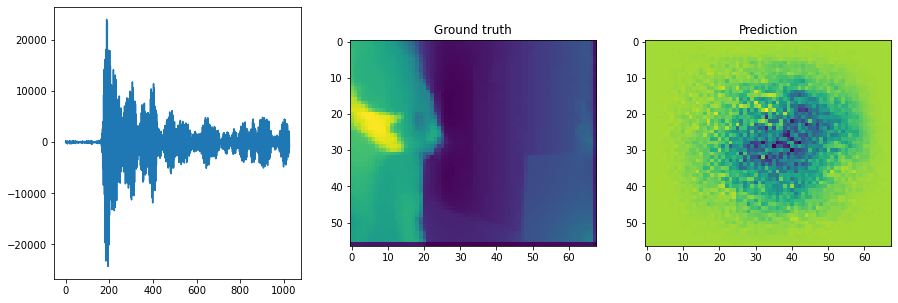

pene


<Figure size 432x288 with 0 Axes>

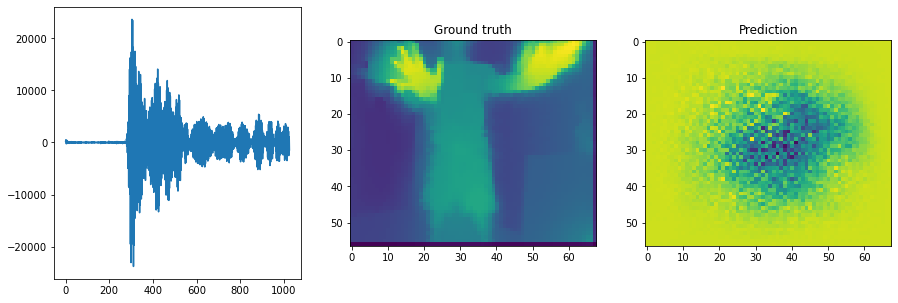

pene


<Figure size 432x288 with 0 Axes>

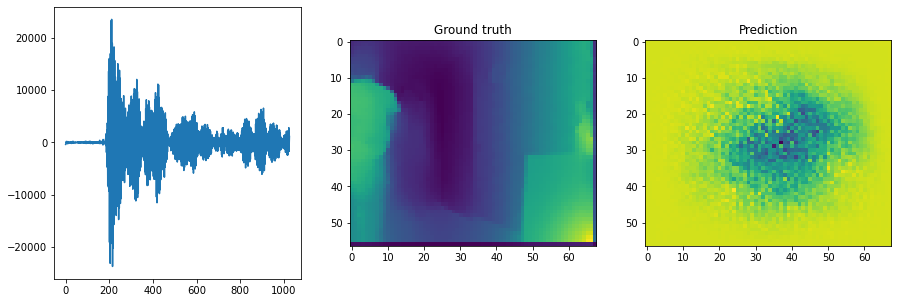

pene


<Figure size 432x288 with 0 Axes>

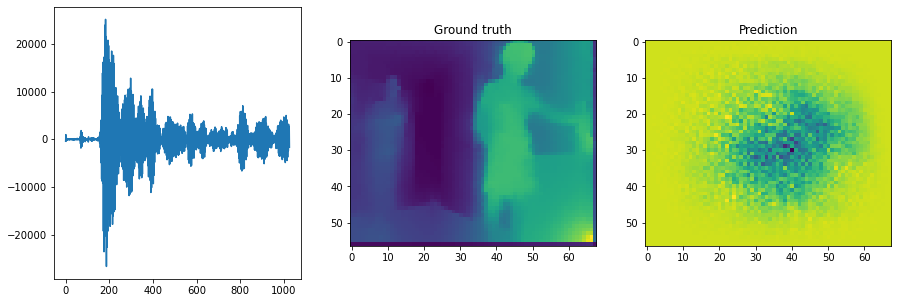

pene


<Figure size 432x288 with 0 Axes>

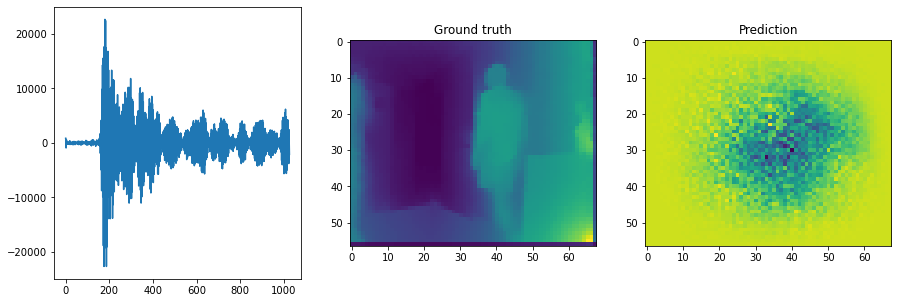

pene


<Figure size 432x288 with 0 Axes>

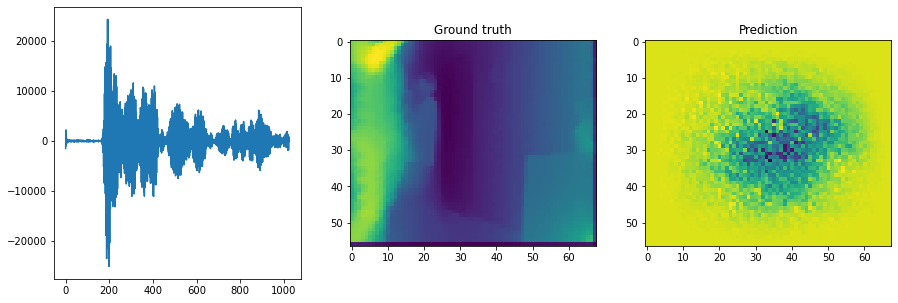

pene


<Figure size 432x288 with 0 Axes>

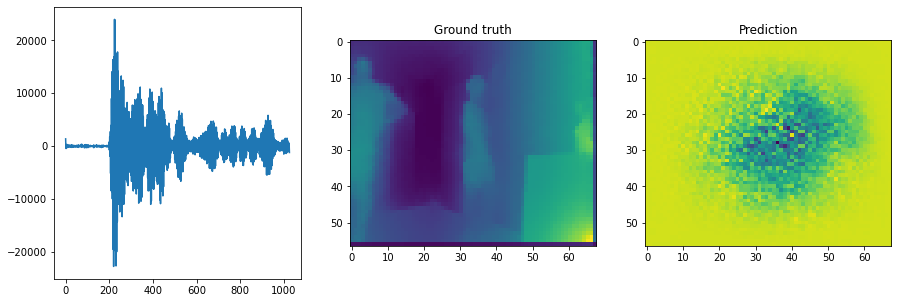

pene


<Figure size 432x288 with 0 Axes>

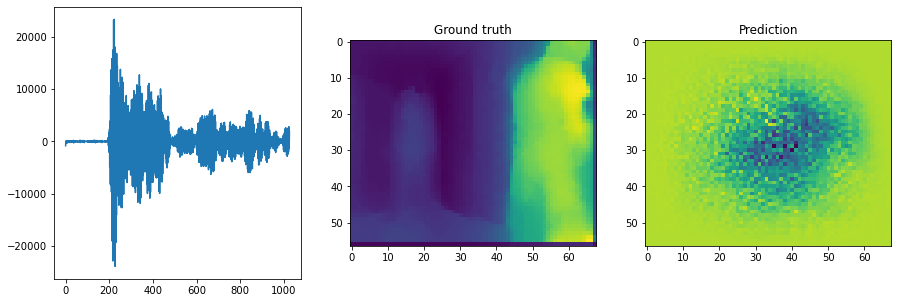

pene


<Figure size 432x288 with 0 Axes>

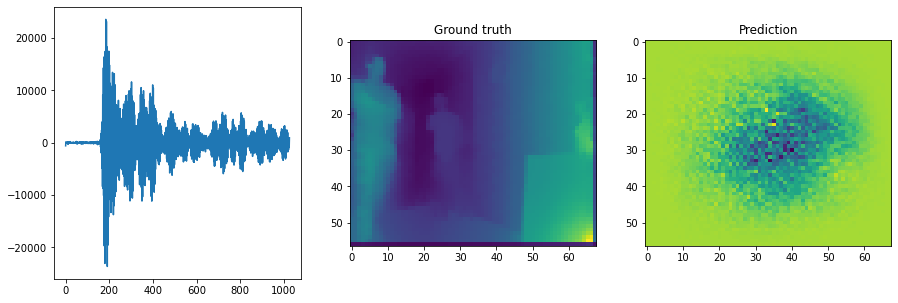

pene


<Figure size 432x288 with 0 Axes>

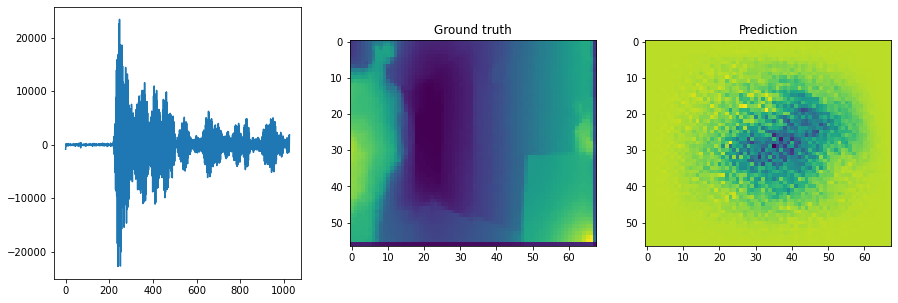

pene


<Figure size 432x288 with 0 Axes>

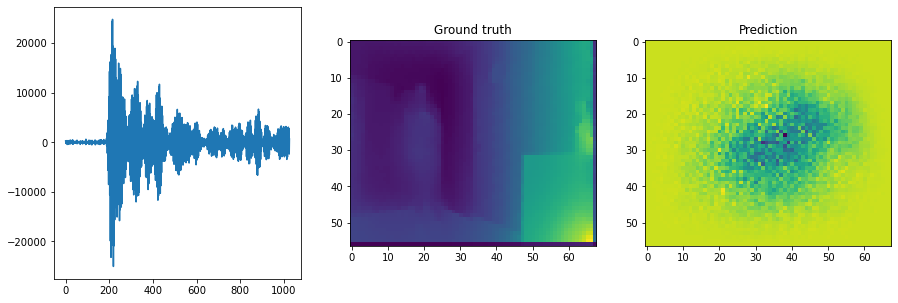

pene


<Figure size 432x288 with 0 Axes>

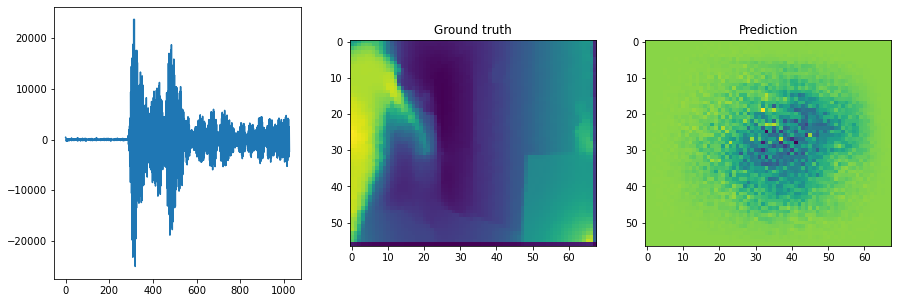

pene


<Figure size 432x288 with 0 Axes>

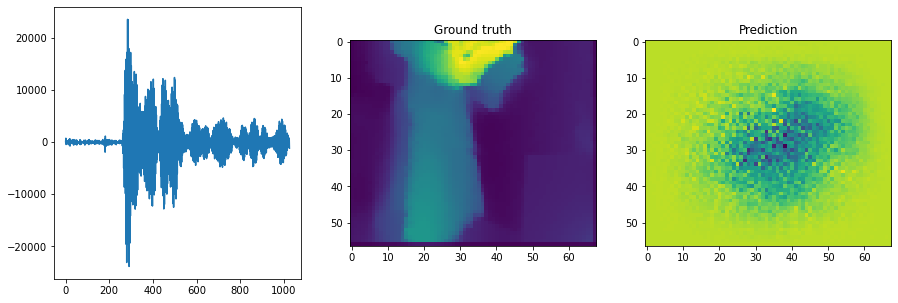

pene


<Figure size 432x288 with 0 Axes>

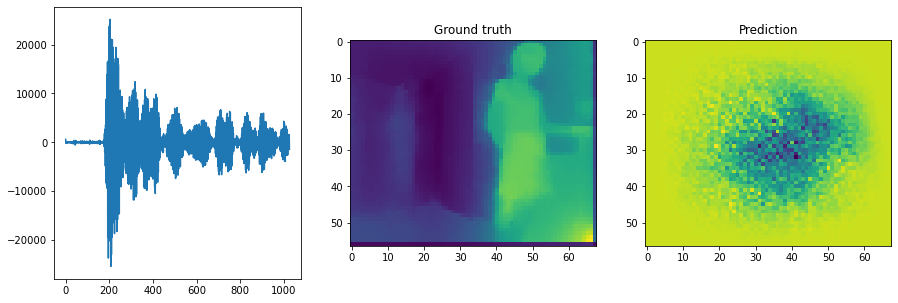

pene


<Figure size 432x288 with 0 Axes>

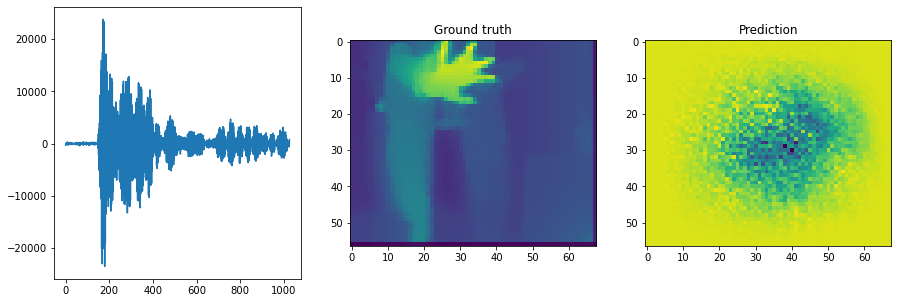

pene


<Figure size 432x288 with 0 Axes>

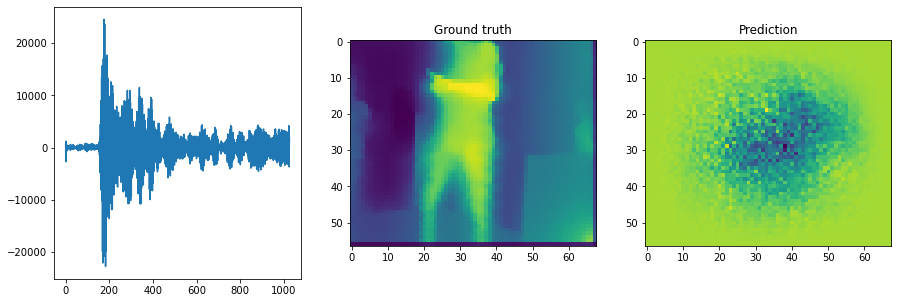

pene


<Figure size 432x288 with 0 Axes>

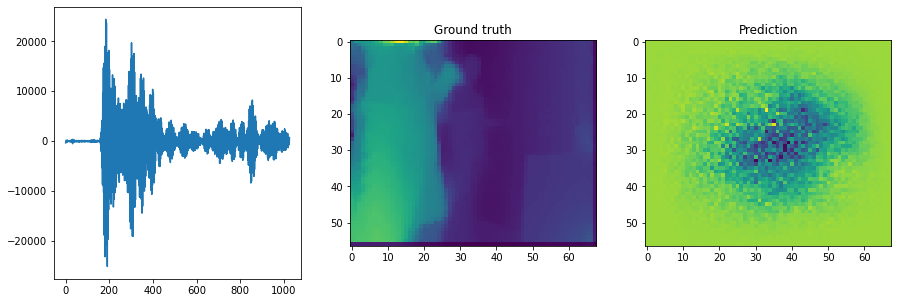

pene


<Figure size 432x288 with 0 Axes>

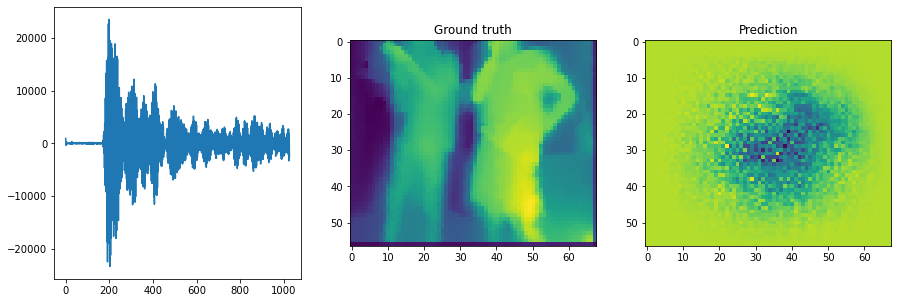

pene


<Figure size 432x288 with 0 Axes>

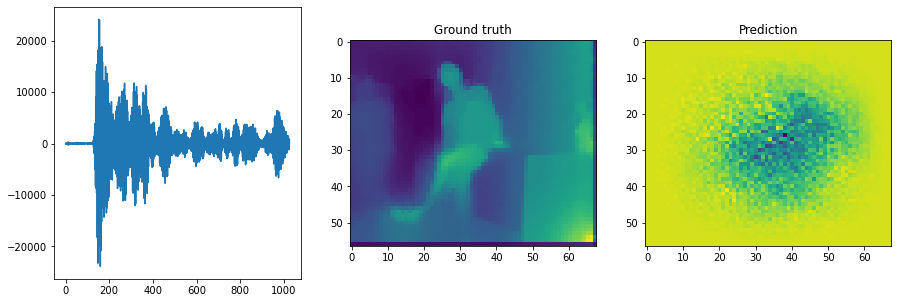

pene


<Figure size 432x288 with 0 Axes>

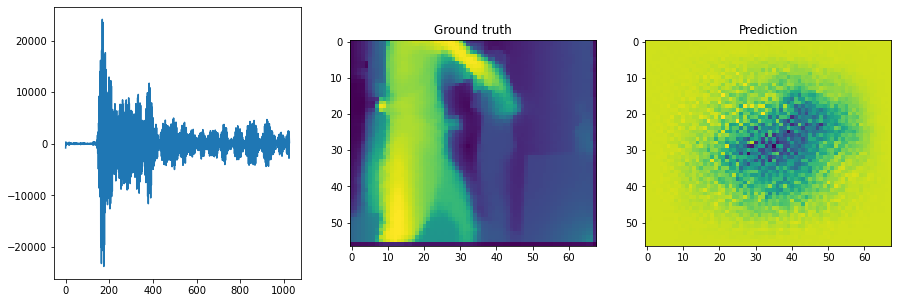

pene


<Figure size 432x288 with 0 Axes>

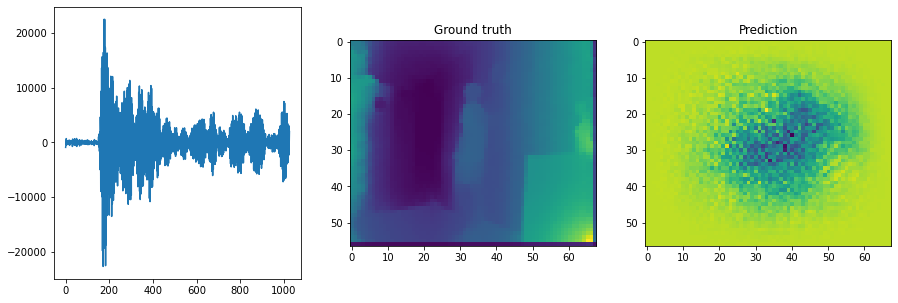

pene


<Figure size 432x288 with 0 Axes>

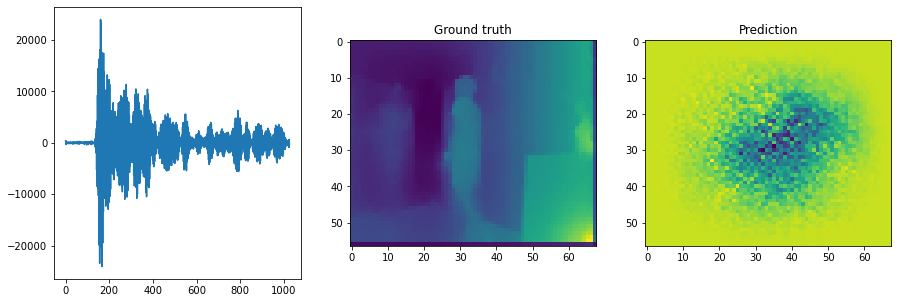

pene


<Figure size 432x288 with 0 Axes>

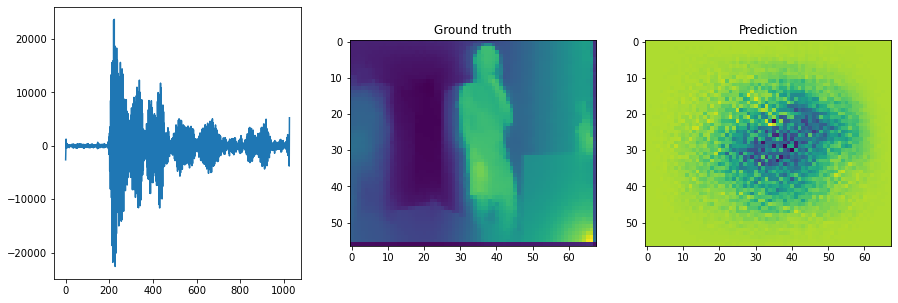

<Figure size 432x288 with 0 Axes>

In [10]:
for idx, (audios, images) in enumerate(val_loader):
    audios = audios.to(device)
    pred_ims = model(audios)
    print(f"\n\nBatch {idx} ###############")
    for audio, image, pred_image in zip(audios, images, pred_ims):
        print("pene")
        audio_np = np.array(audio.to('cpu').detach().numpy())
        image_np = np.array(image.to('cpu').detach().numpy())
        pred_image_np = np.array(pred_image.to('cpu').detach().numpy())
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        axs[0].plot(audio_np)
        axs[1].imshow(image_np)
        axs[1].set_title("Ground truth")
        axs[2].imshow(pred_image_np)
        axs[2].set_title("Prediction")
        plt.show()
        plt.clf()



Batch 0 ###############
pene


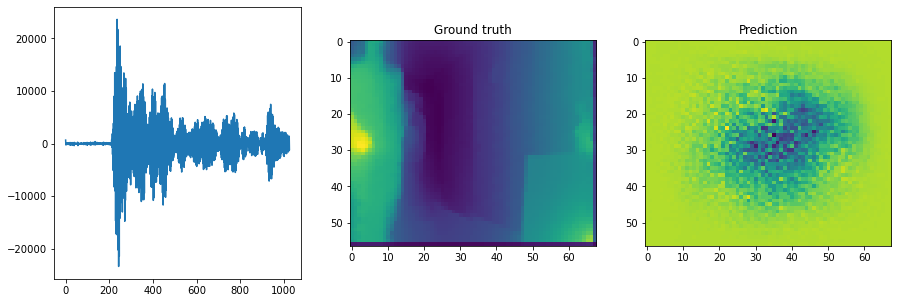

pene


<Figure size 432x288 with 0 Axes>

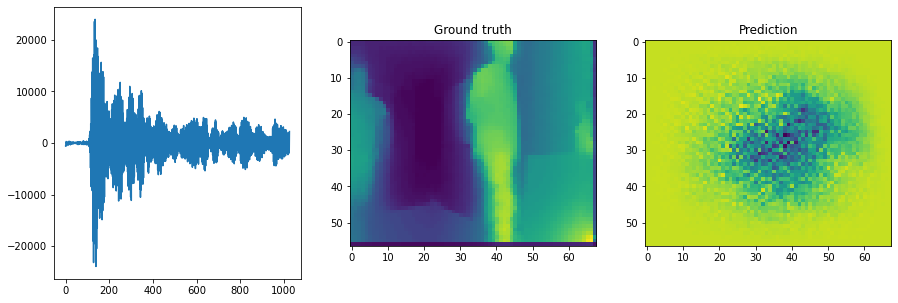

pene


<Figure size 432x288 with 0 Axes>

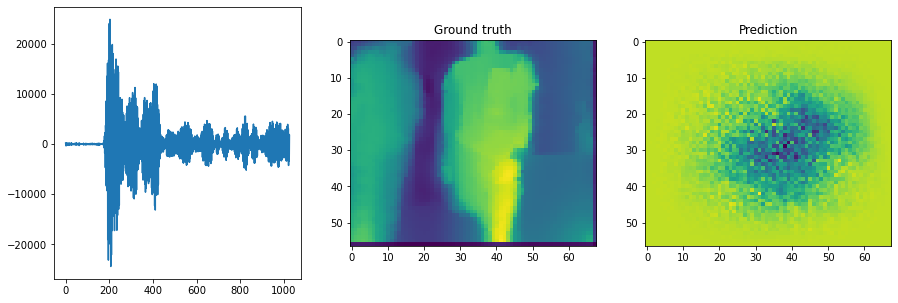

pene


<Figure size 432x288 with 0 Axes>

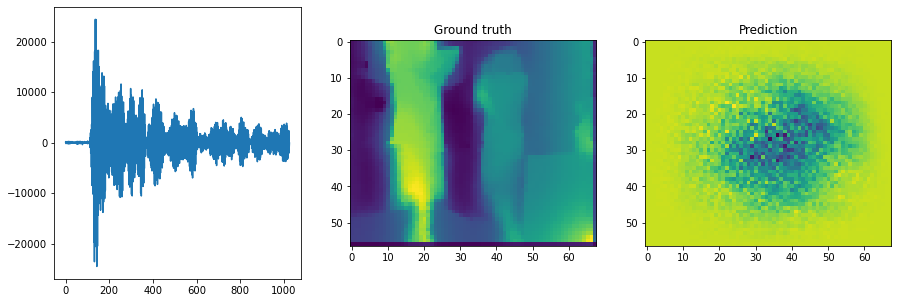

pene


<Figure size 432x288 with 0 Axes>

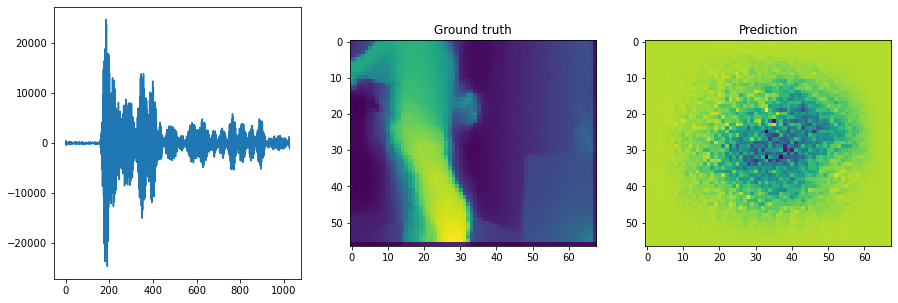

pene


<Figure size 432x288 with 0 Axes>

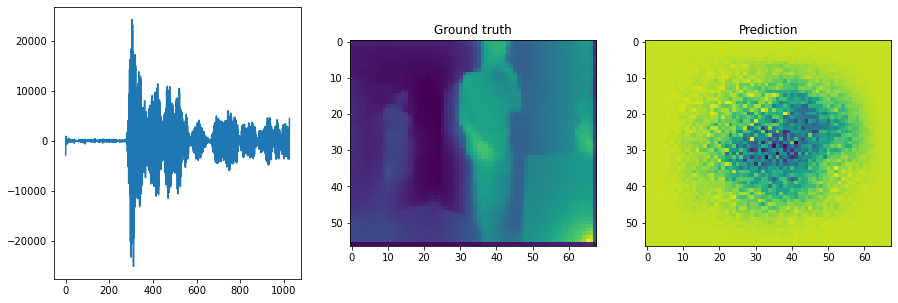

pene


<Figure size 432x288 with 0 Axes>

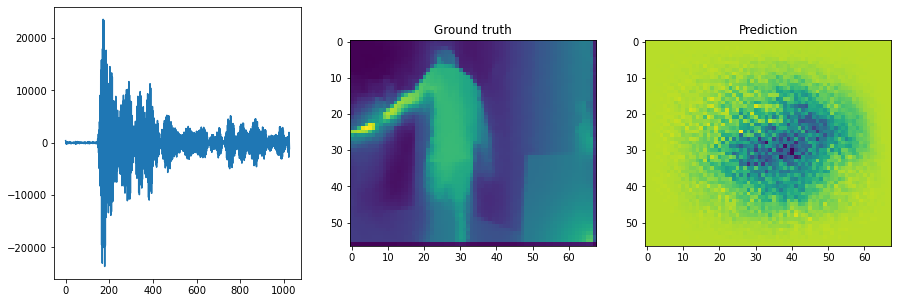

pene


<Figure size 432x288 with 0 Axes>

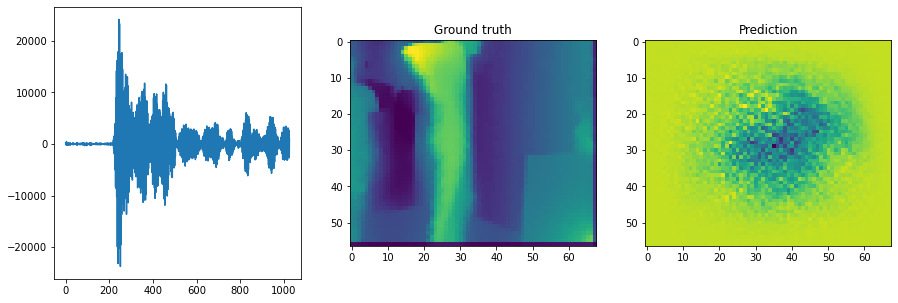

pene


<Figure size 432x288 with 0 Axes>

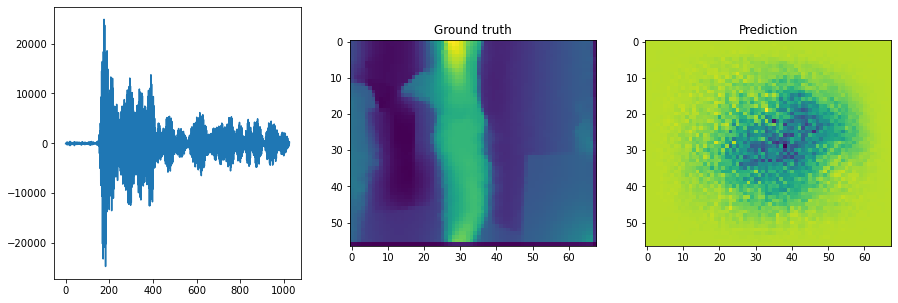

pene


<Figure size 432x288 with 0 Axes>

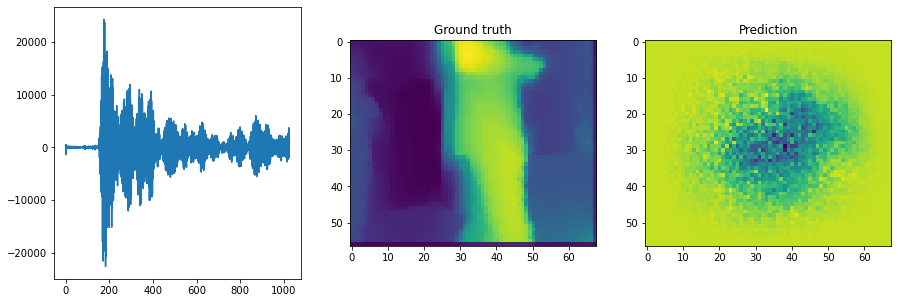

pene


<Figure size 432x288 with 0 Axes>

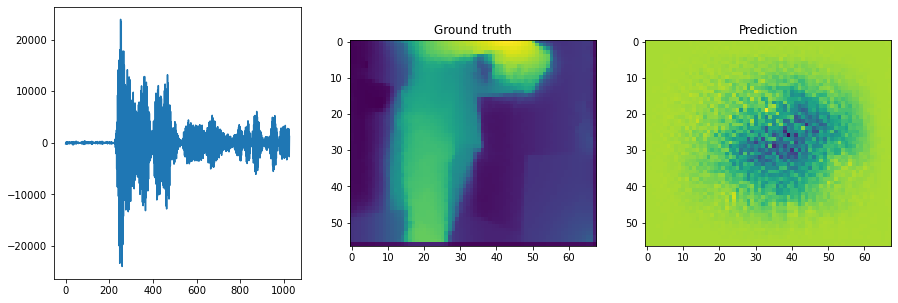

pene


<Figure size 432x288 with 0 Axes>

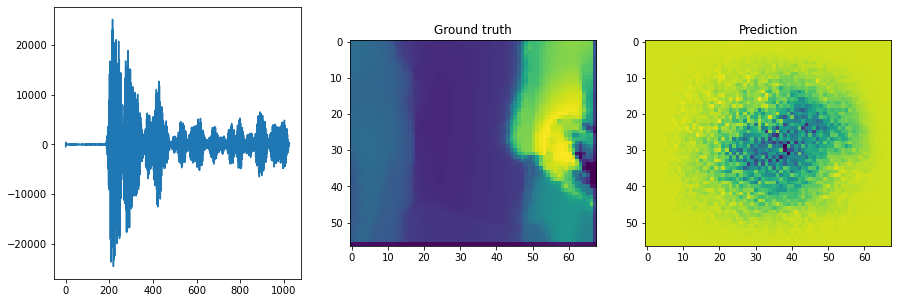

pene


<Figure size 432x288 with 0 Axes>

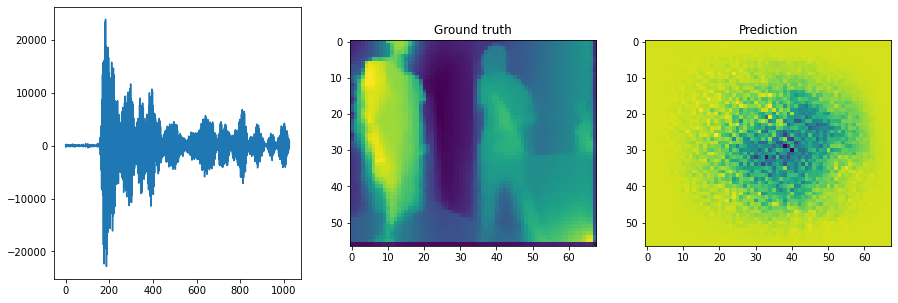

pene


<Figure size 432x288 with 0 Axes>

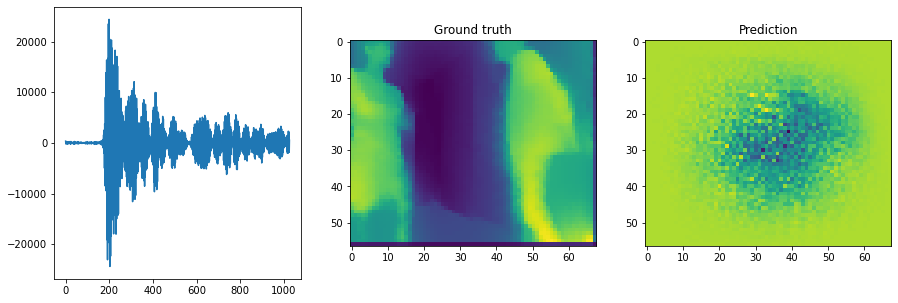

pene


<Figure size 432x288 with 0 Axes>

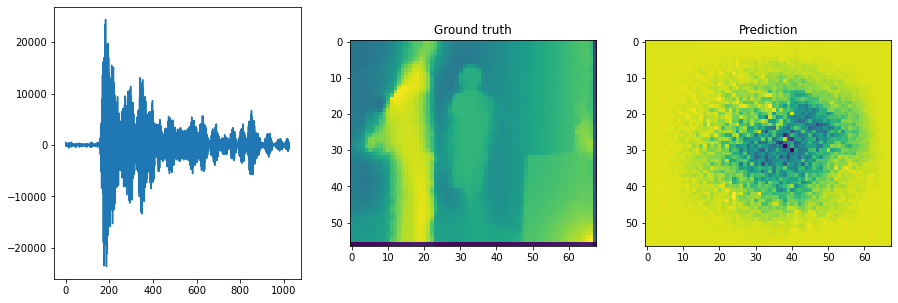

pene


<Figure size 432x288 with 0 Axes>

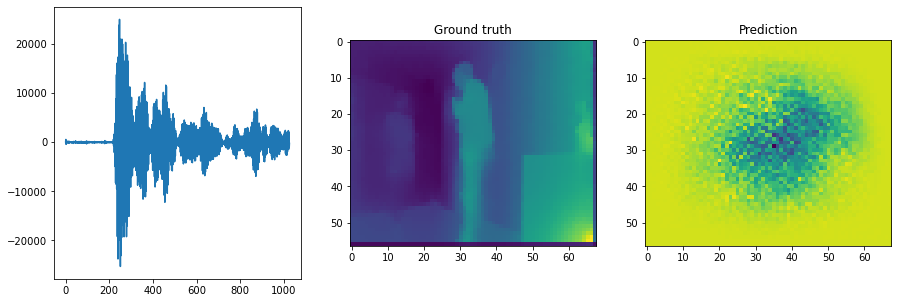

pene


<Figure size 432x288 with 0 Axes>

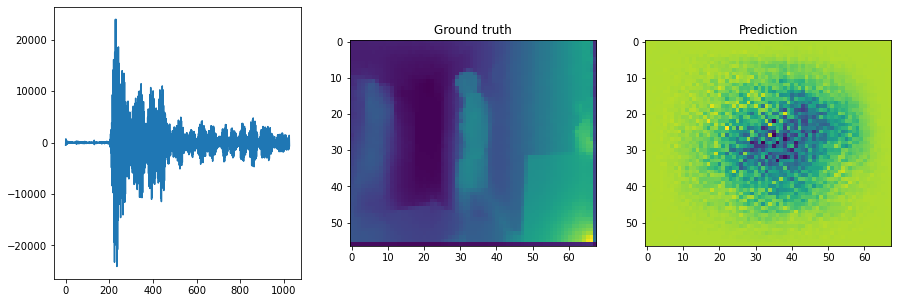

pene


<Figure size 432x288 with 0 Axes>

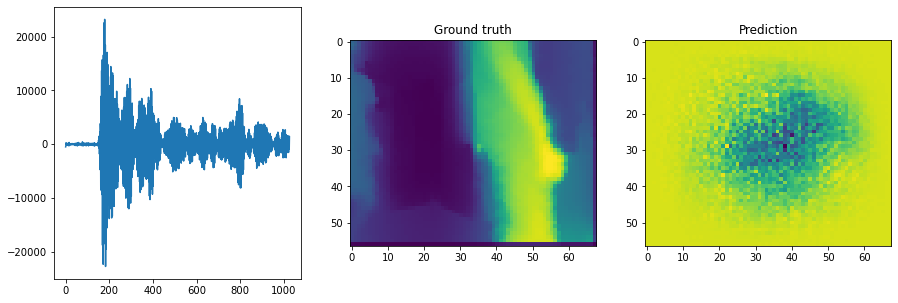

pene


<Figure size 432x288 with 0 Axes>

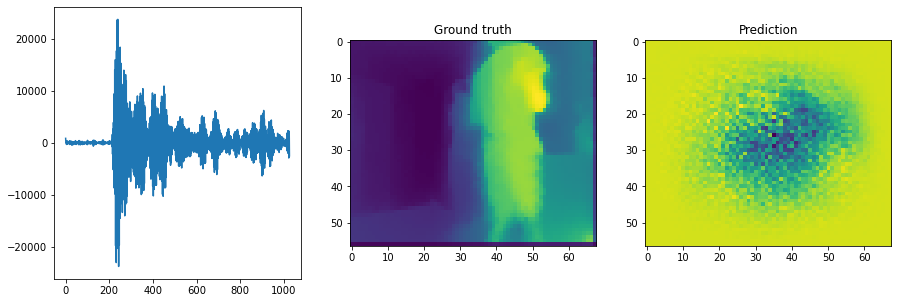

pene


<Figure size 432x288 with 0 Axes>

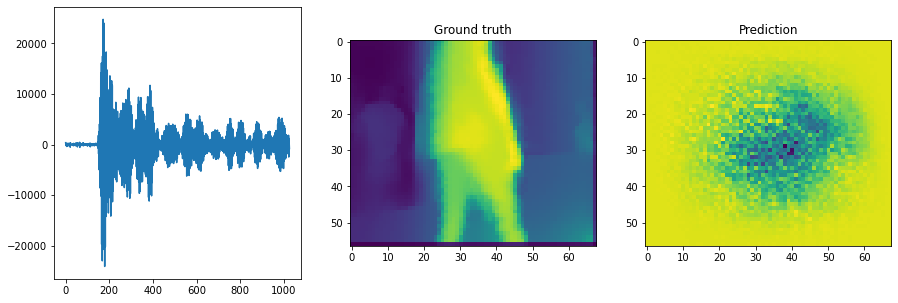

pene


<Figure size 432x288 with 0 Axes>

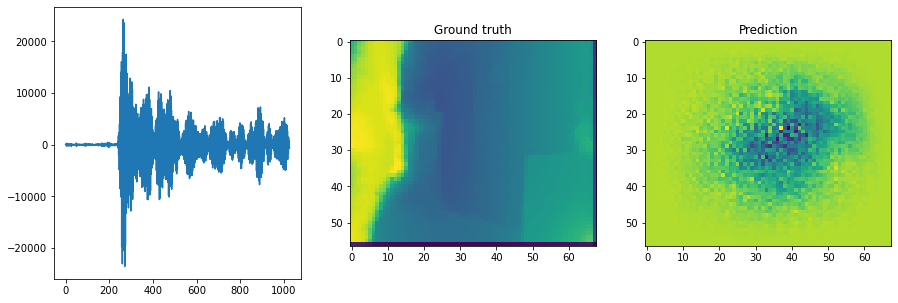

pene


<Figure size 432x288 with 0 Axes>

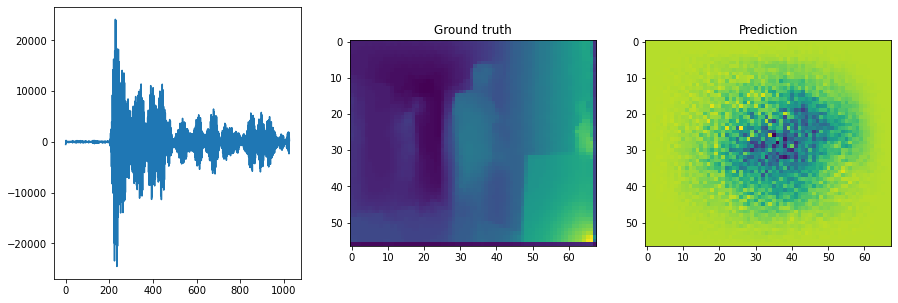

pene


<Figure size 432x288 with 0 Axes>

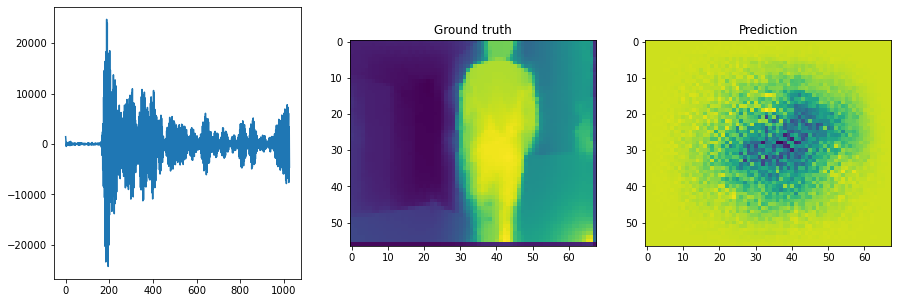

pene


<Figure size 432x288 with 0 Axes>

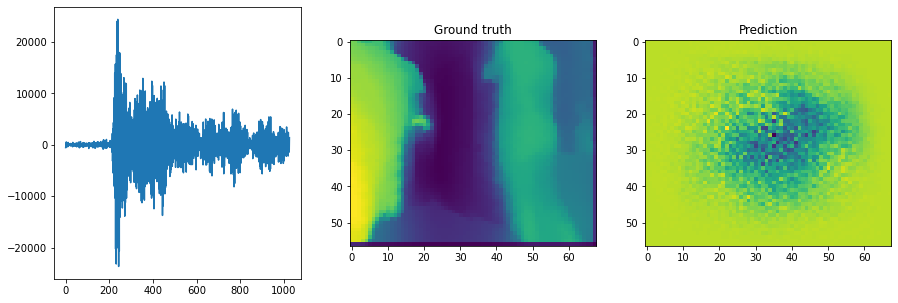

pene


<Figure size 432x288 with 0 Axes>

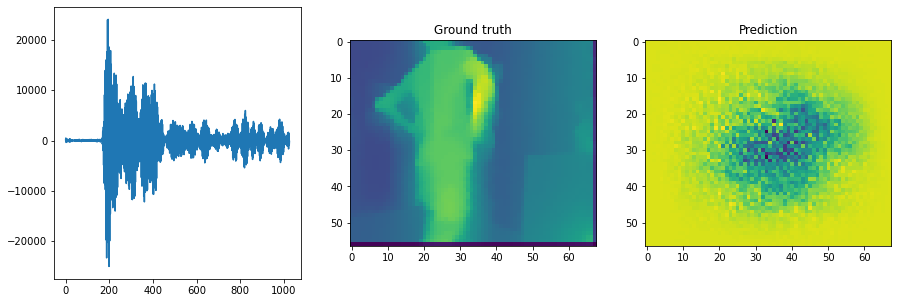

pene


<Figure size 432x288 with 0 Axes>

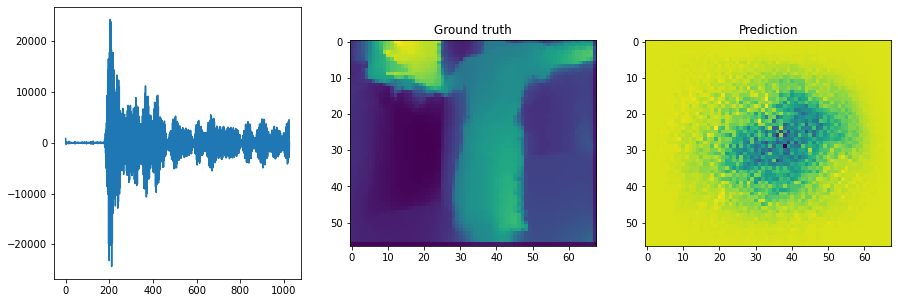

pene


<Figure size 432x288 with 0 Axes>

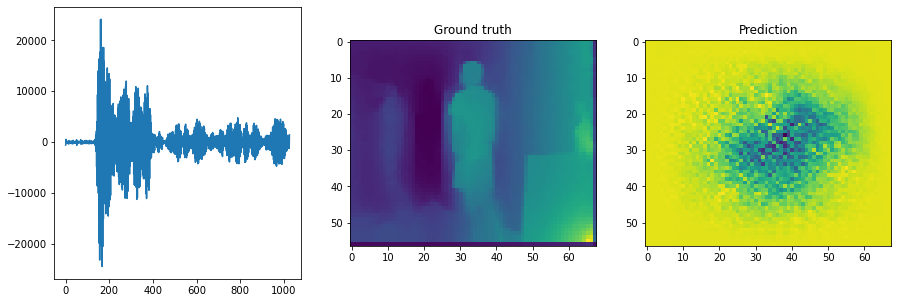

pene


<Figure size 432x288 with 0 Axes>

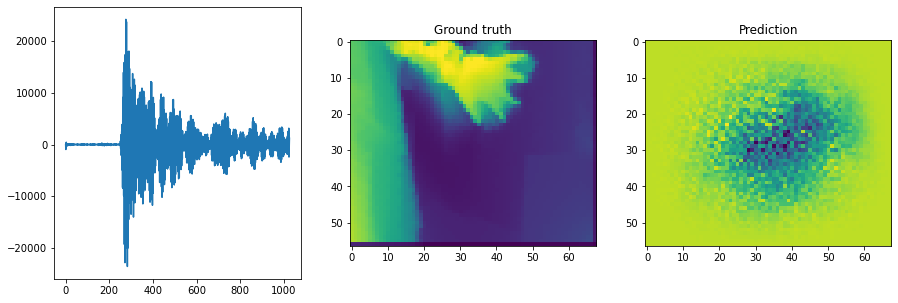

pene


<Figure size 432x288 with 0 Axes>

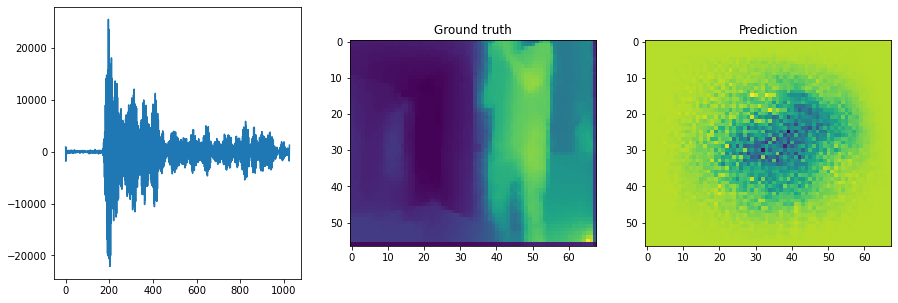

pene


<Figure size 432x288 with 0 Axes>

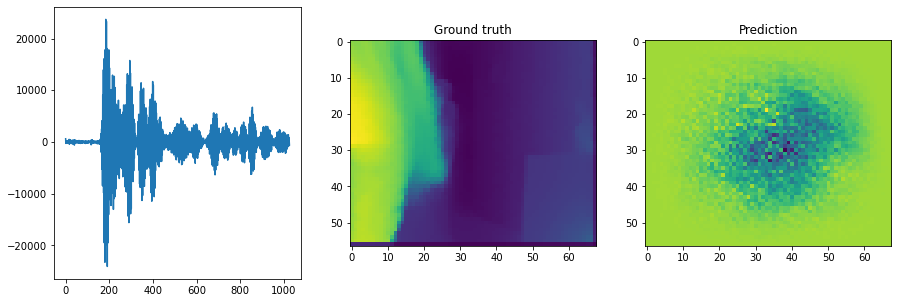

pene


<Figure size 432x288 with 0 Axes>

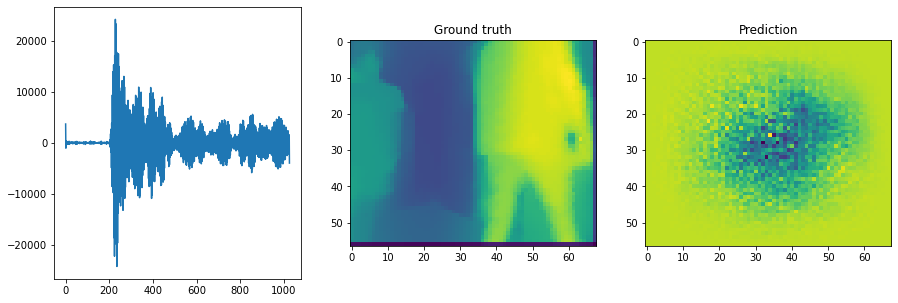

pene


<Figure size 432x288 with 0 Axes>

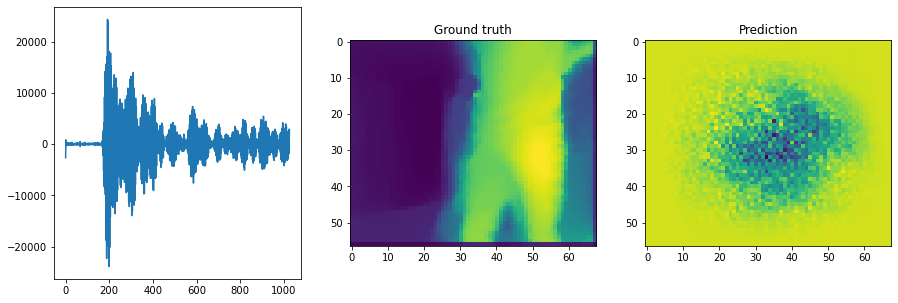

pene


<Figure size 432x288 with 0 Axes>

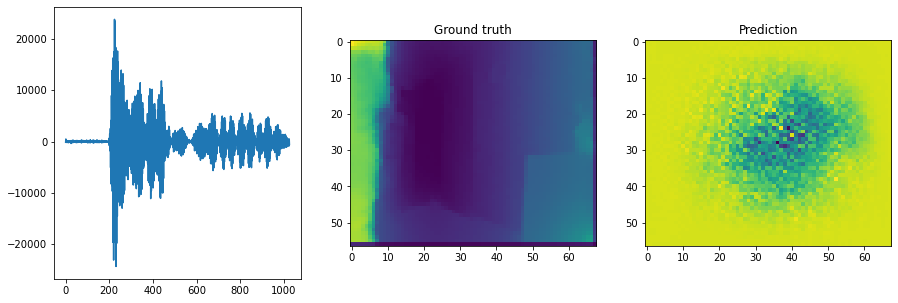

pene


<Figure size 432x288 with 0 Axes>

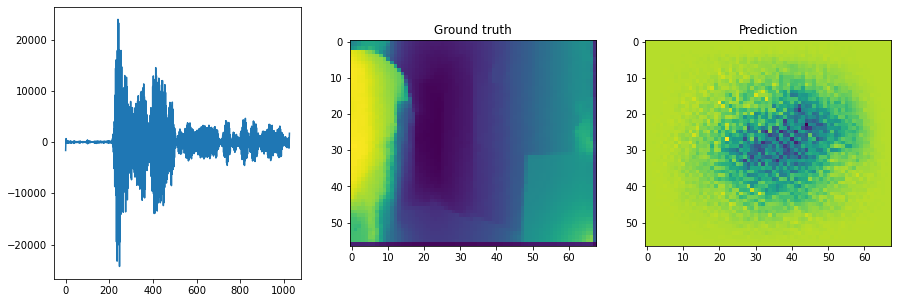

pene


<Figure size 432x288 with 0 Axes>

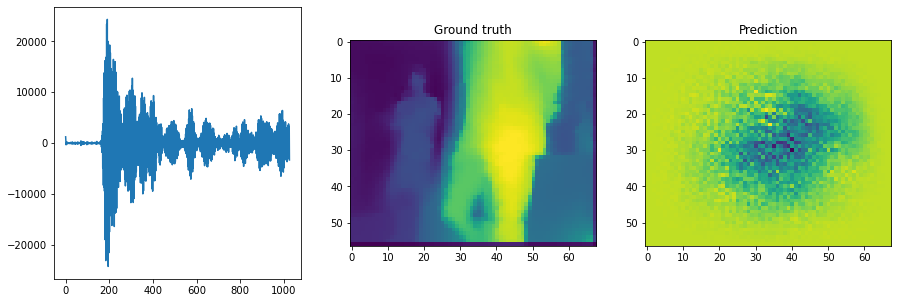

pene


<Figure size 432x288 with 0 Axes>

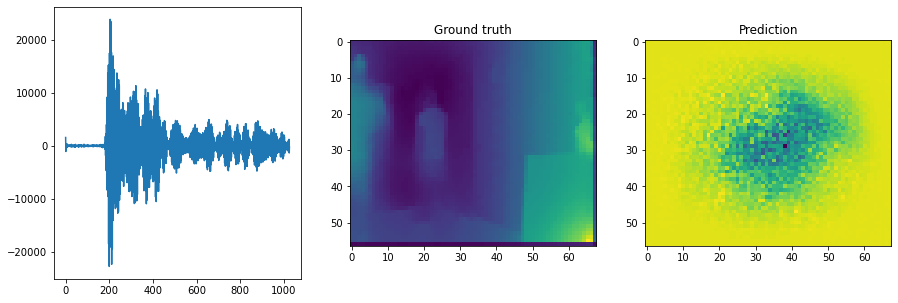

pene


<Figure size 432x288 with 0 Axes>

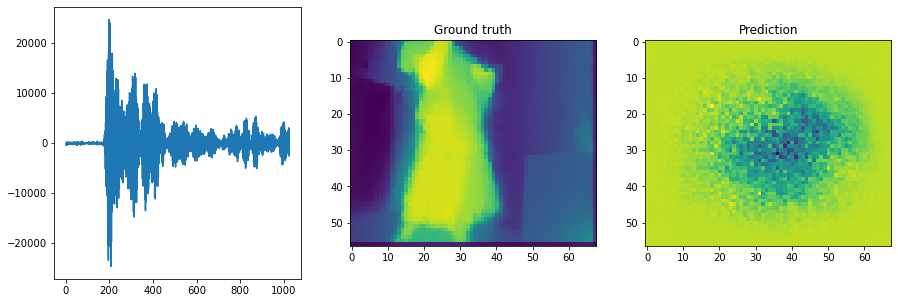

pene


<Figure size 432x288 with 0 Axes>

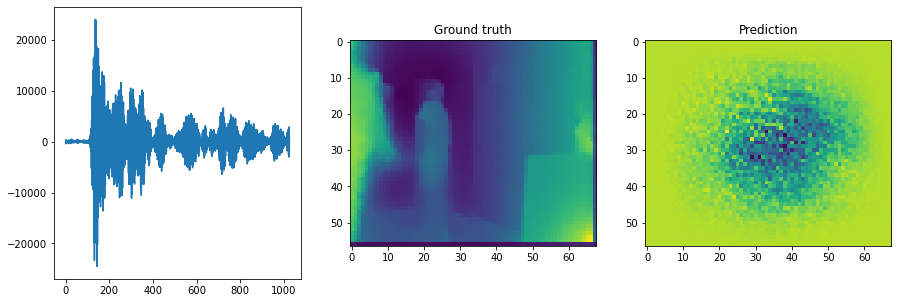

pene


<Figure size 432x288 with 0 Axes>

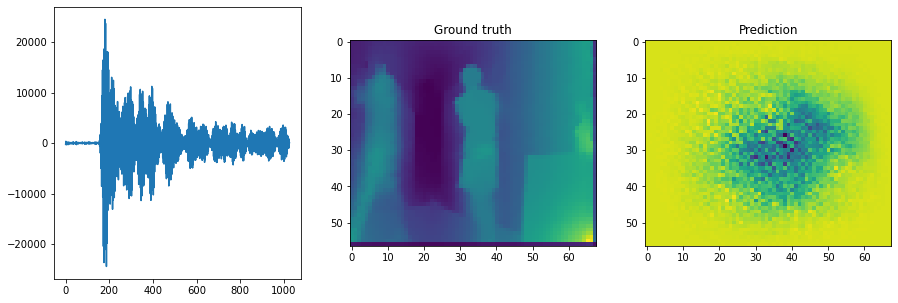

pene


<Figure size 432x288 with 0 Axes>

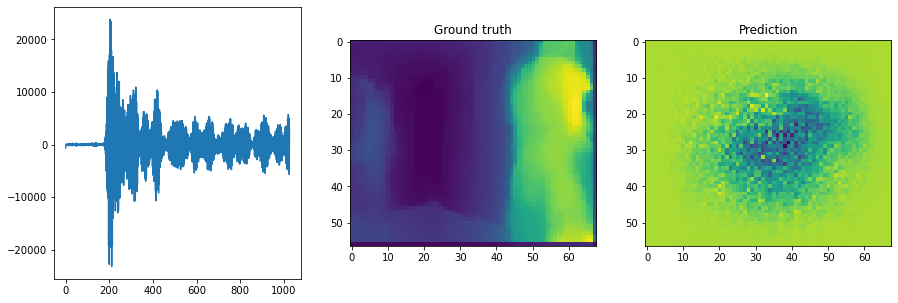

pene


<Figure size 432x288 with 0 Axes>

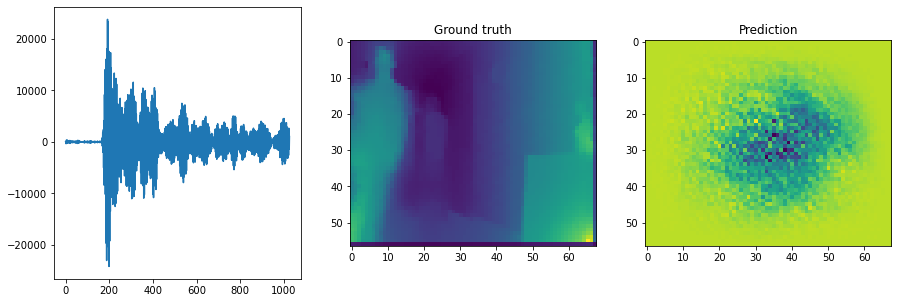

pene


<Figure size 432x288 with 0 Axes>

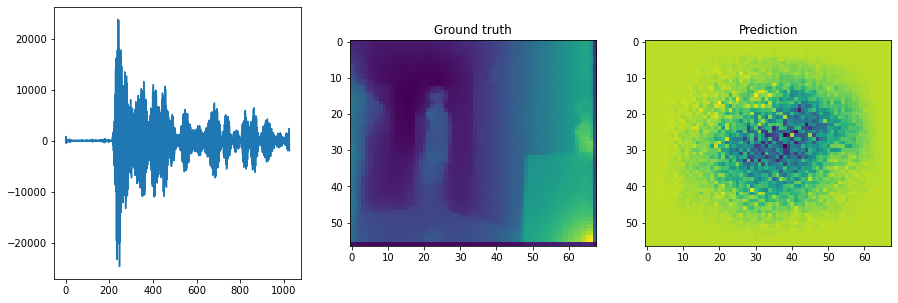

pene


<Figure size 432x288 with 0 Axes>

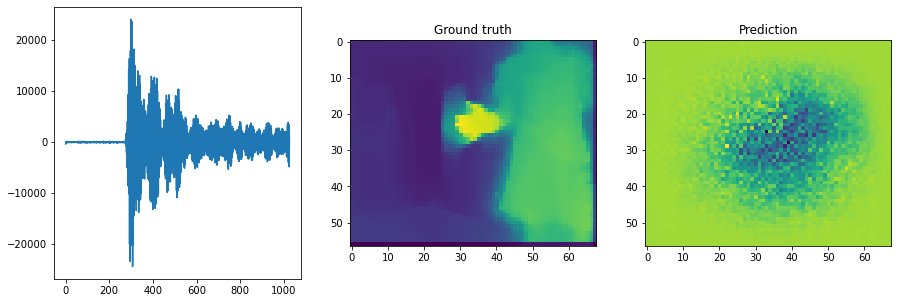

pene


<Figure size 432x288 with 0 Axes>

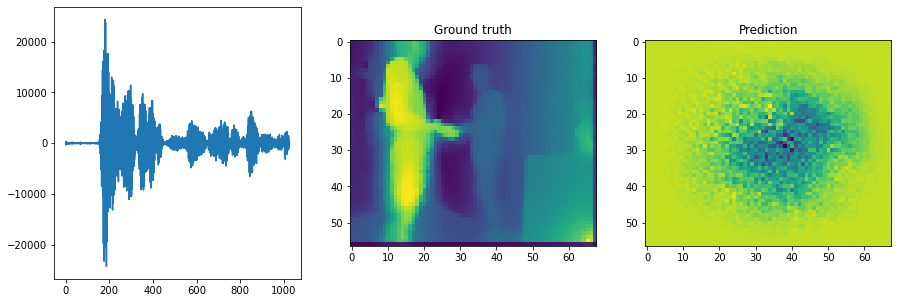

pene


<Figure size 432x288 with 0 Axes>

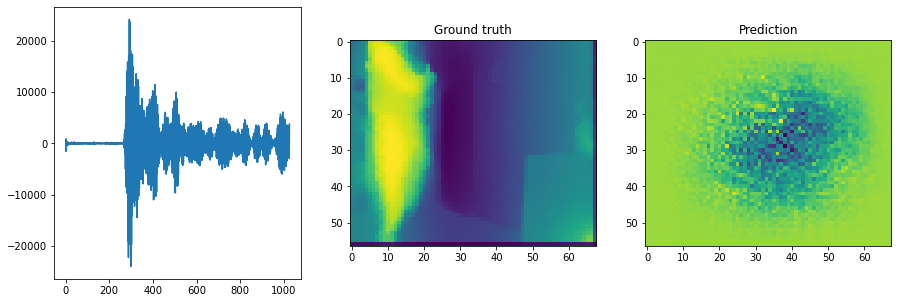

pene


<Figure size 432x288 with 0 Axes>

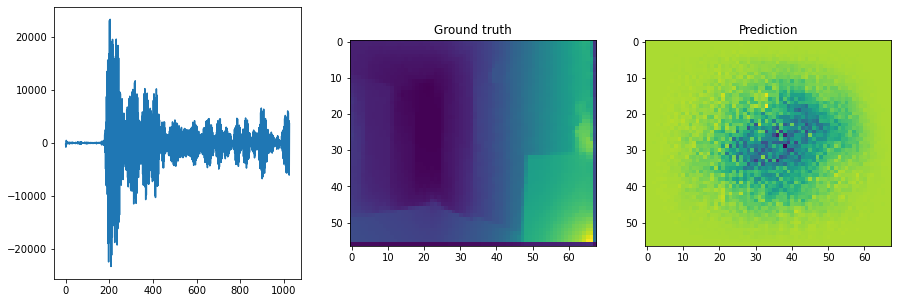

pene


<Figure size 432x288 with 0 Axes>

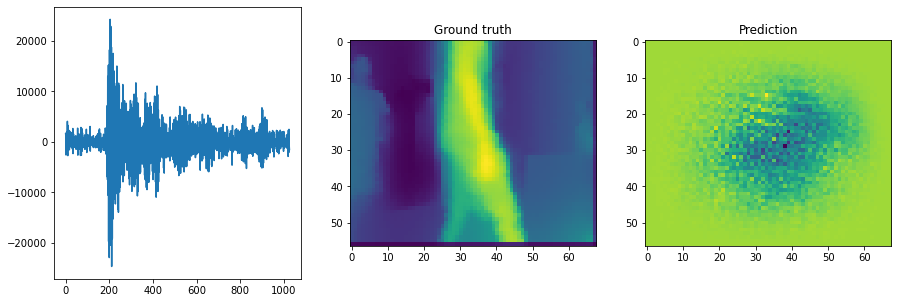

pene


<Figure size 432x288 with 0 Axes>

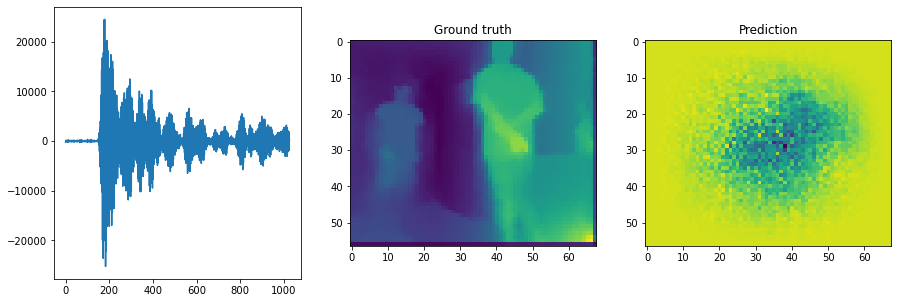

pene


<Figure size 432x288 with 0 Axes>

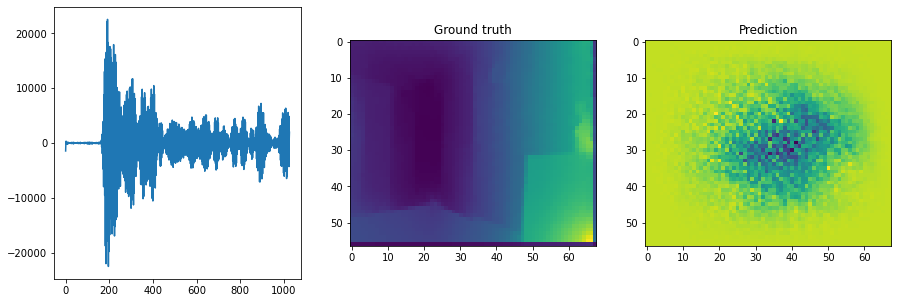

pene


<Figure size 432x288 with 0 Axes>

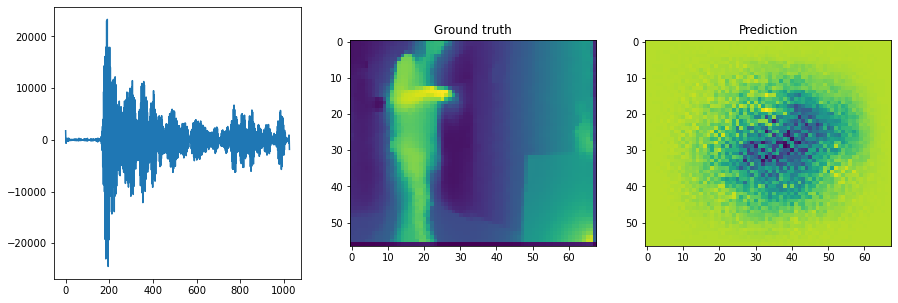

pene


<Figure size 432x288 with 0 Axes>

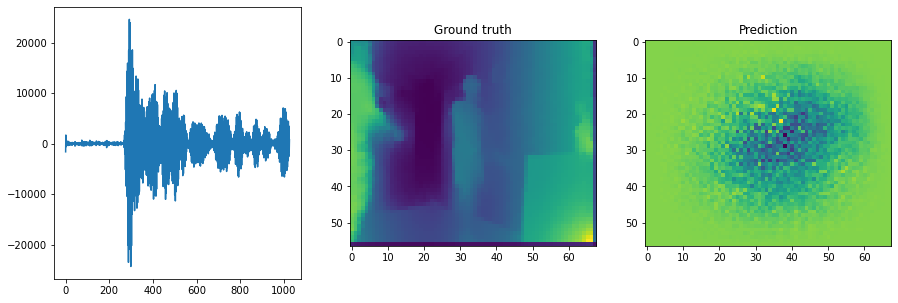

pene


<Figure size 432x288 with 0 Axes>

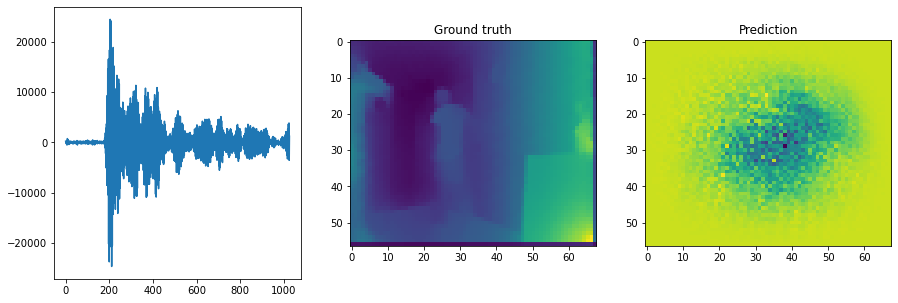

pene


<Figure size 432x288 with 0 Axes>

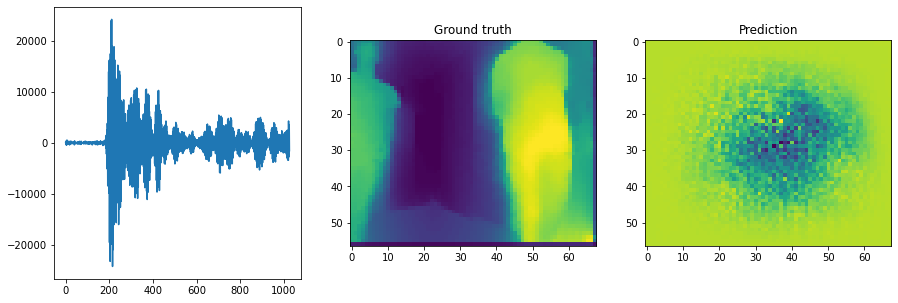

pene


<Figure size 432x288 with 0 Axes>

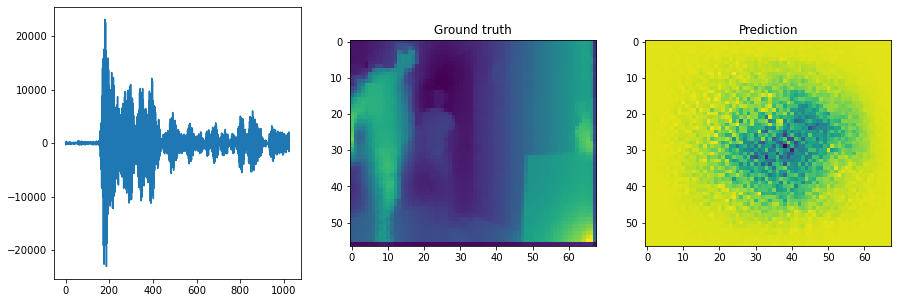

pene


<Figure size 432x288 with 0 Axes>

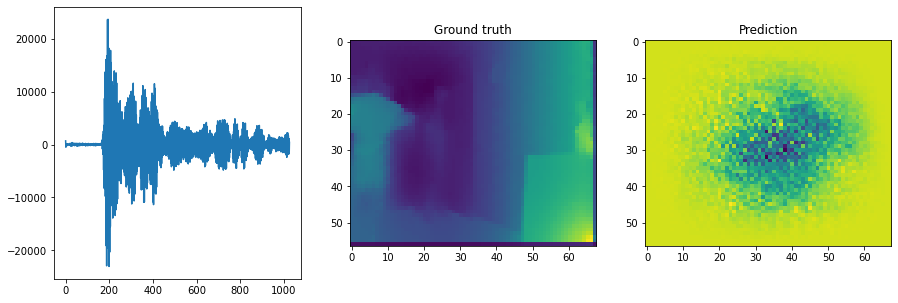

pene


<Figure size 432x288 with 0 Axes>

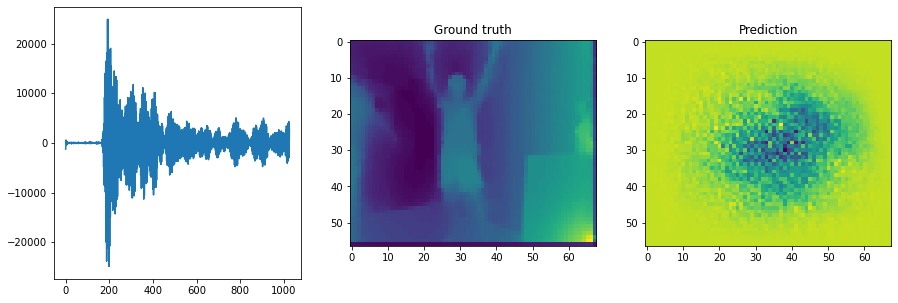

pene


<Figure size 432x288 with 0 Axes>

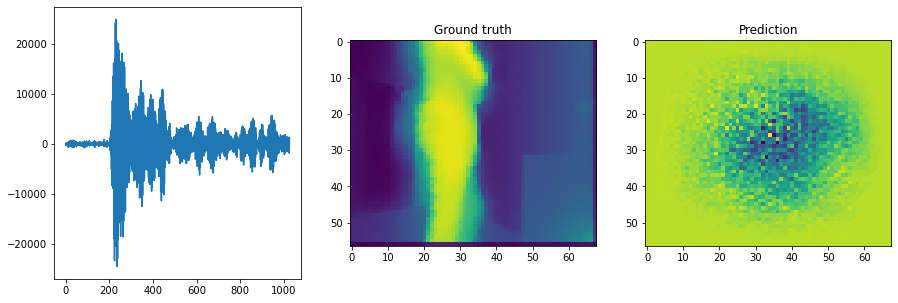

pene


<Figure size 432x288 with 0 Axes>

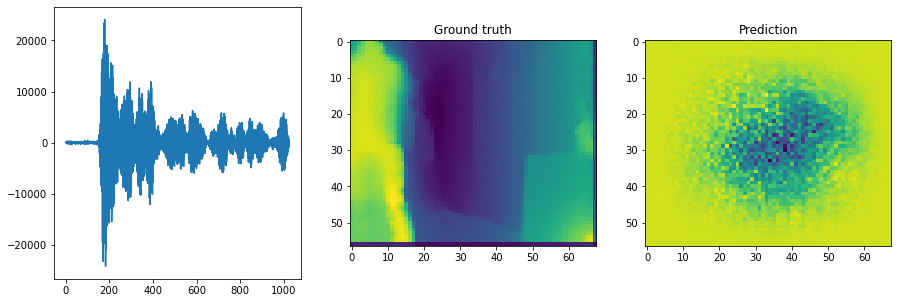

pene


<Figure size 432x288 with 0 Axes>

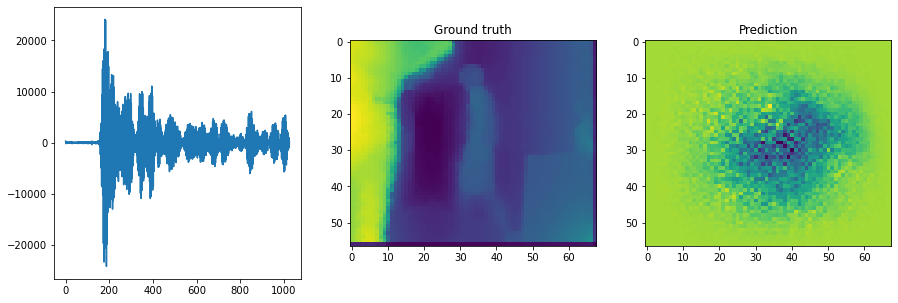

pene


<Figure size 432x288 with 0 Axes>

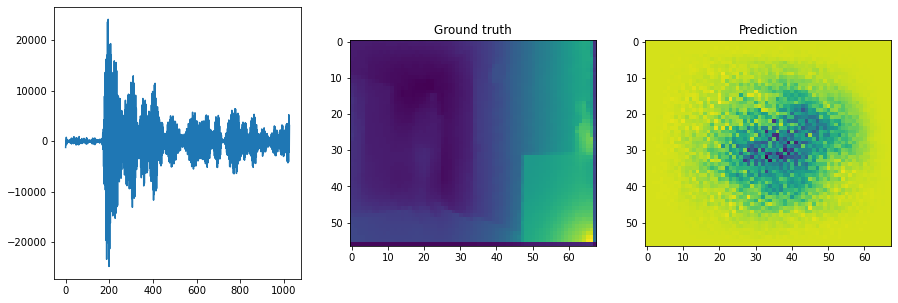

pene


<Figure size 432x288 with 0 Axes>

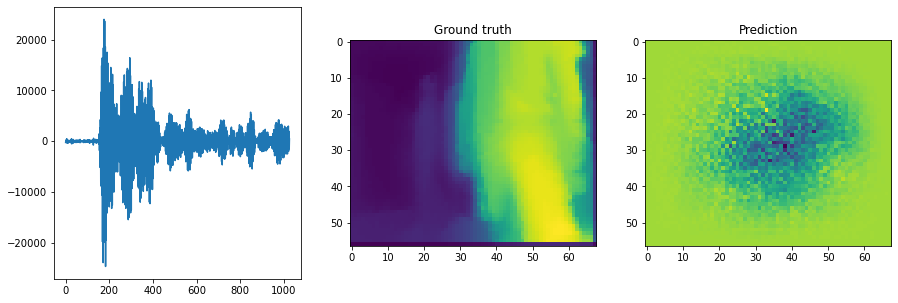

pene


<Figure size 432x288 with 0 Axes>

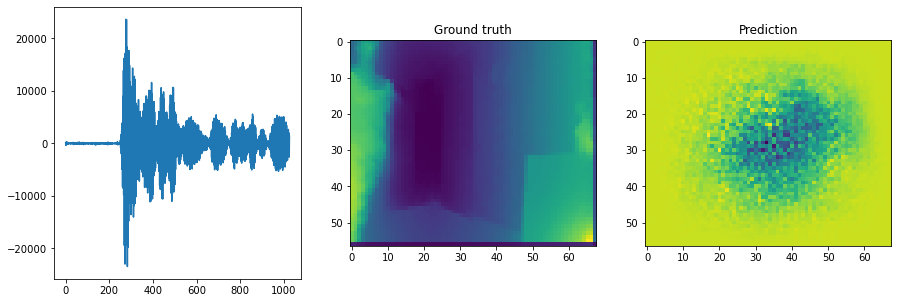

pene


<Figure size 432x288 with 0 Axes>

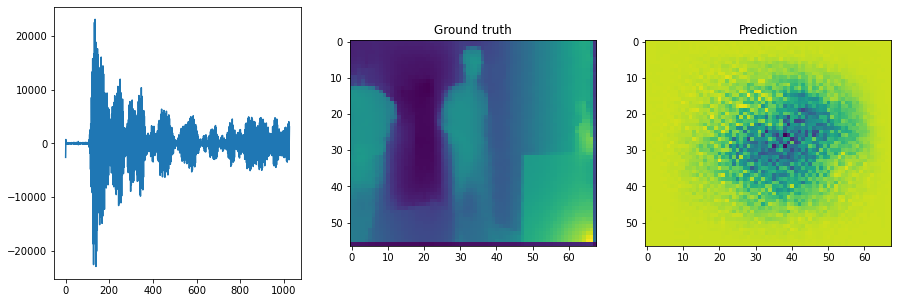

pene


<Figure size 432x288 with 0 Axes>

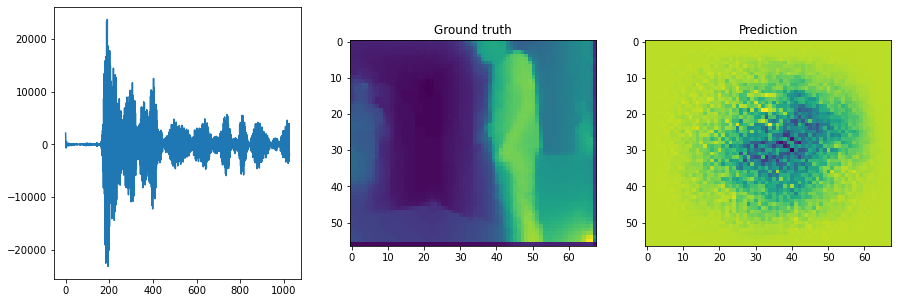

pene


<Figure size 432x288 with 0 Axes>

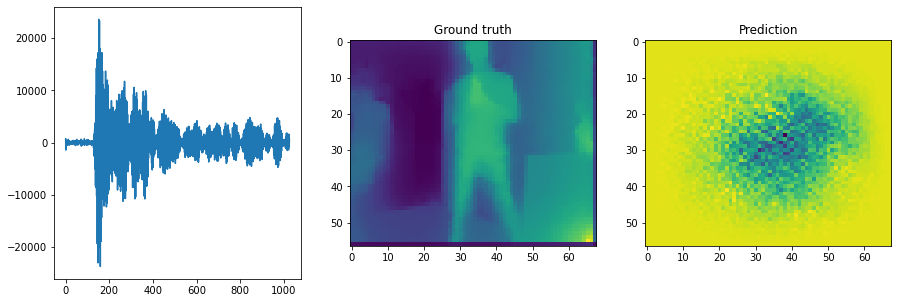

pene


<Figure size 432x288 with 0 Axes>

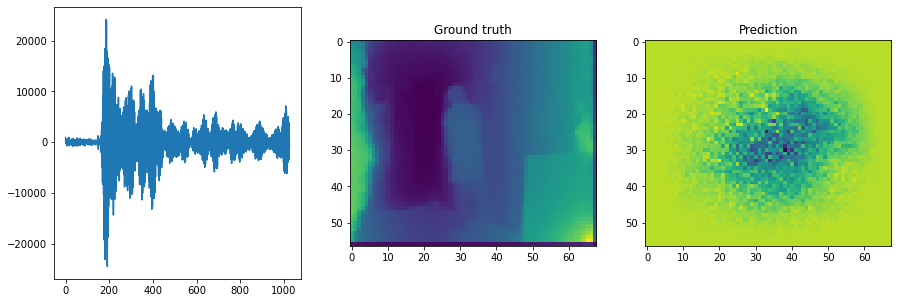

pene


<Figure size 432x288 with 0 Axes>

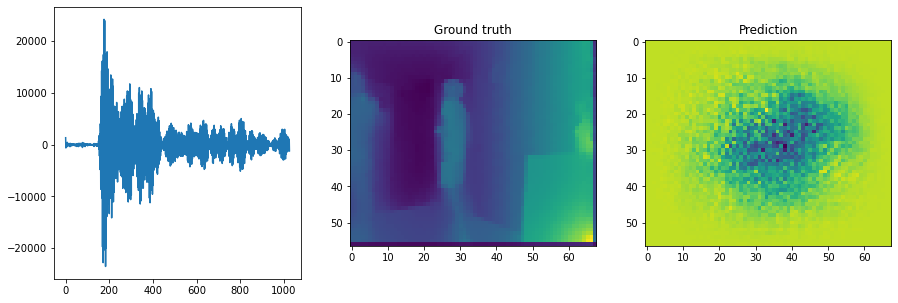

pene


<Figure size 432x288 with 0 Axes>

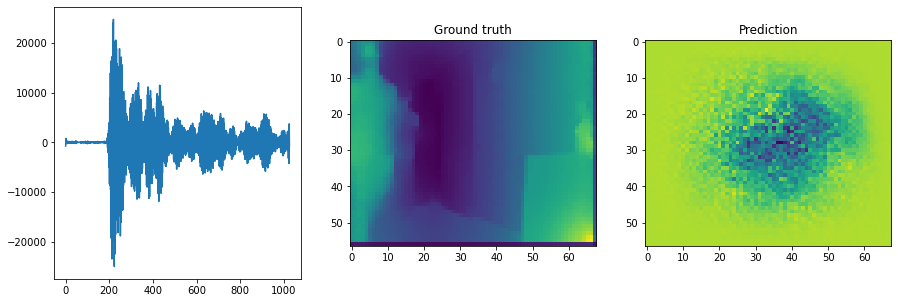

pene


<Figure size 432x288 with 0 Axes>

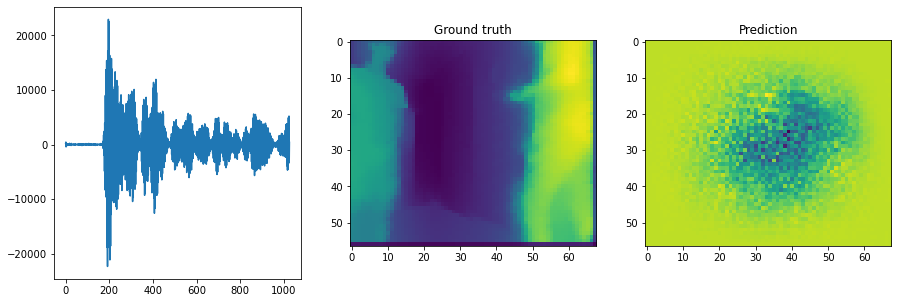

pene


<Figure size 432x288 with 0 Axes>

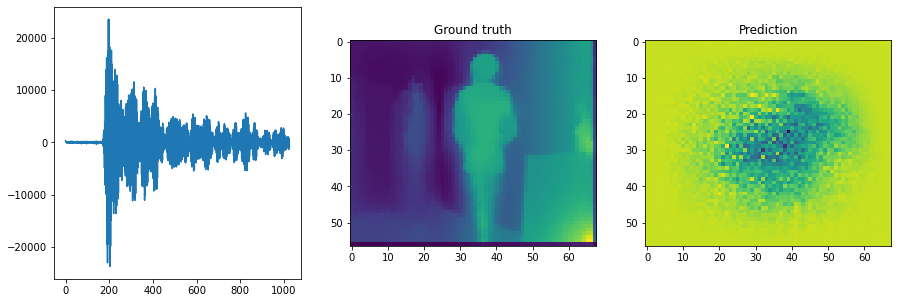

pene


<Figure size 432x288 with 0 Axes>

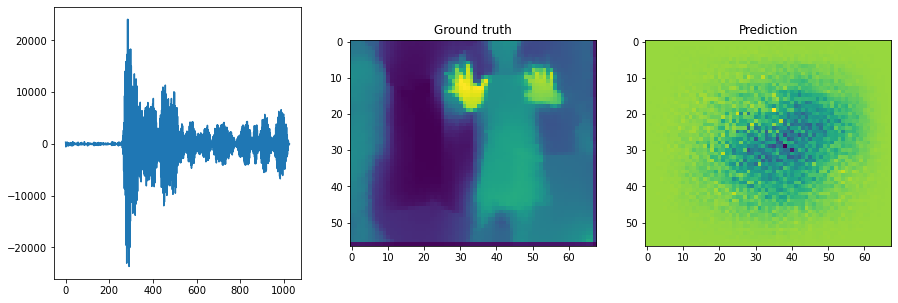

pene


<Figure size 432x288 with 0 Axes>

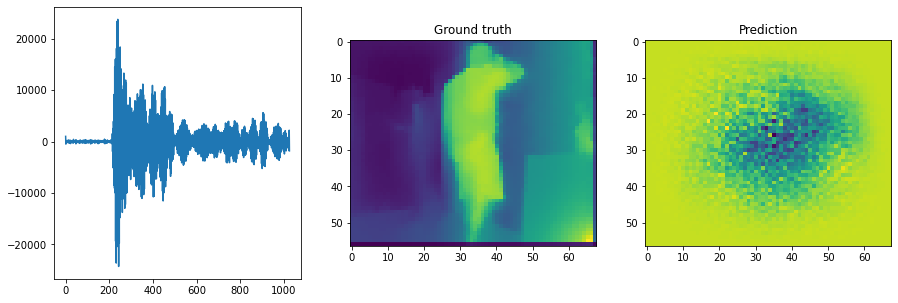

pene


<Figure size 432x288 with 0 Axes>

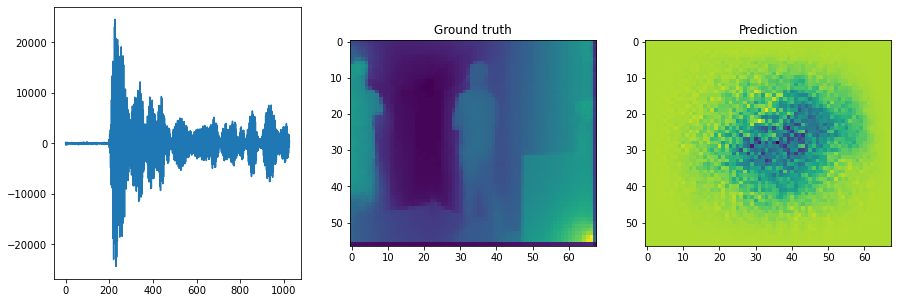

pene


<Figure size 432x288 with 0 Axes>

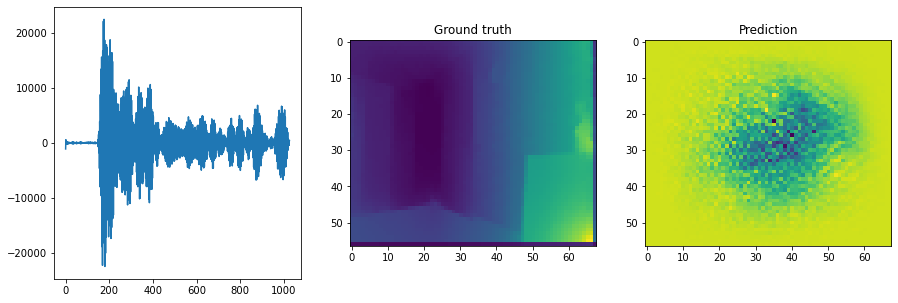

pene


<Figure size 432x288 with 0 Axes>

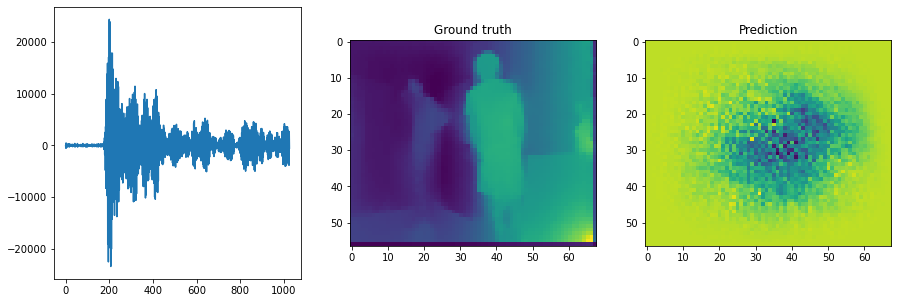

pene


<Figure size 432x288 with 0 Axes>

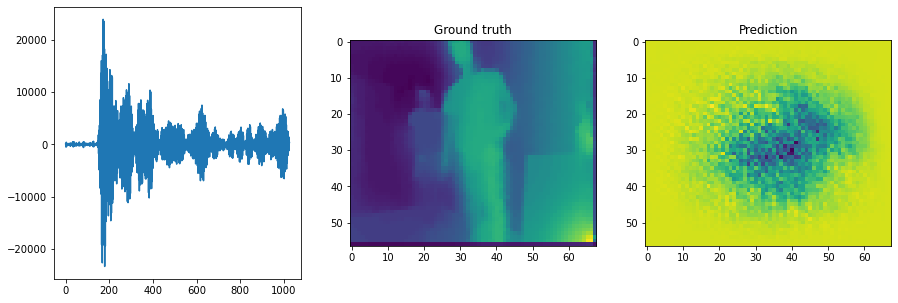

pene


<Figure size 432x288 with 0 Axes>

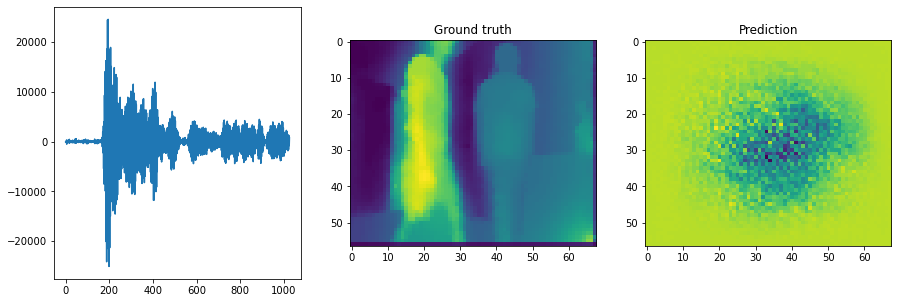

pene


<Figure size 432x288 with 0 Axes>

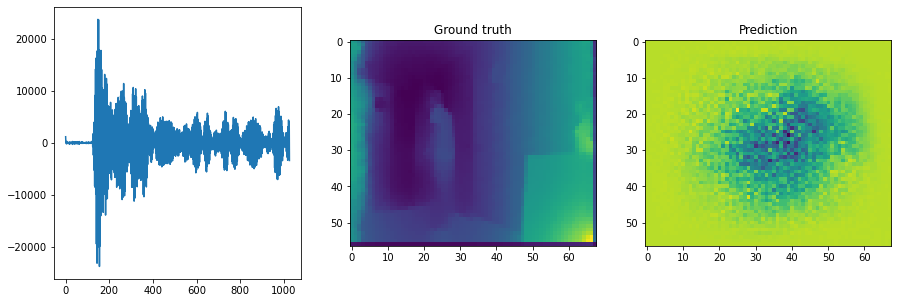

pene


<Figure size 432x288 with 0 Axes>

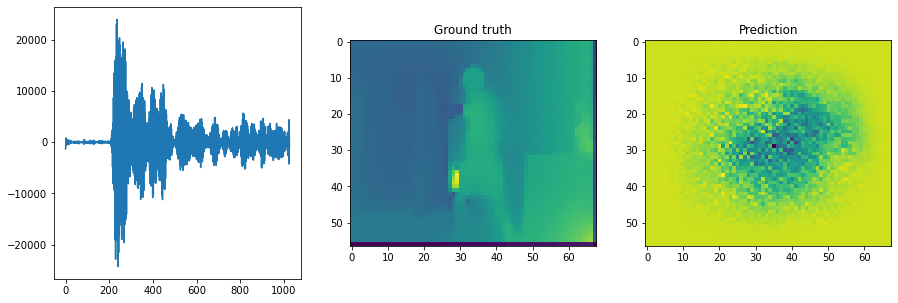

pene


<Figure size 432x288 with 0 Axes>

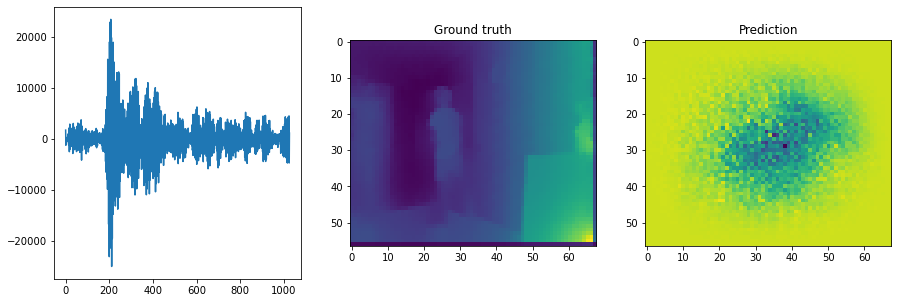

pene


<Figure size 432x288 with 0 Axes>

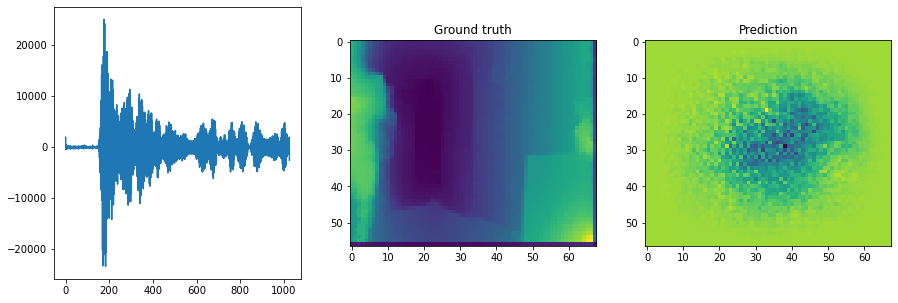

pene


<Figure size 432x288 with 0 Axes>

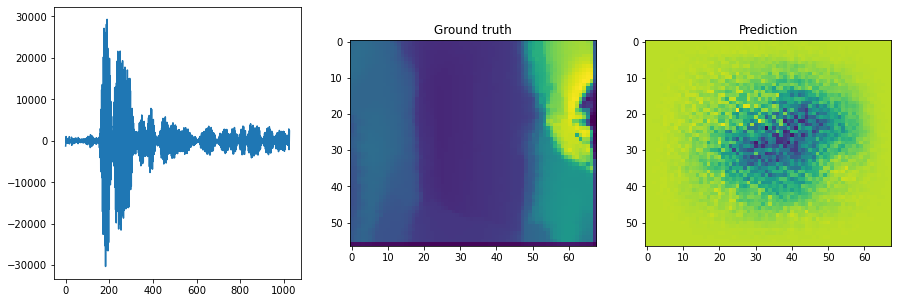

pene


<Figure size 432x288 with 0 Axes>

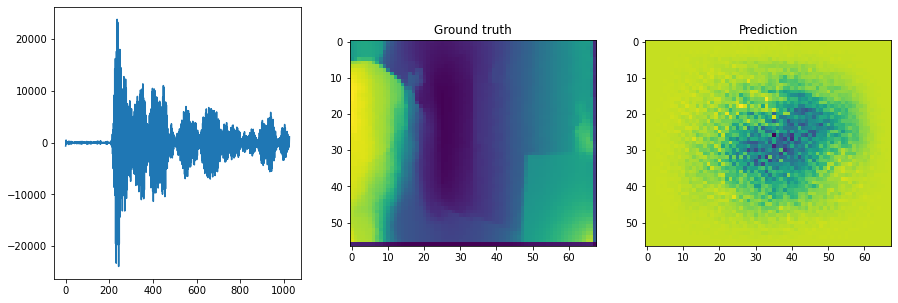

pene


<Figure size 432x288 with 0 Axes>

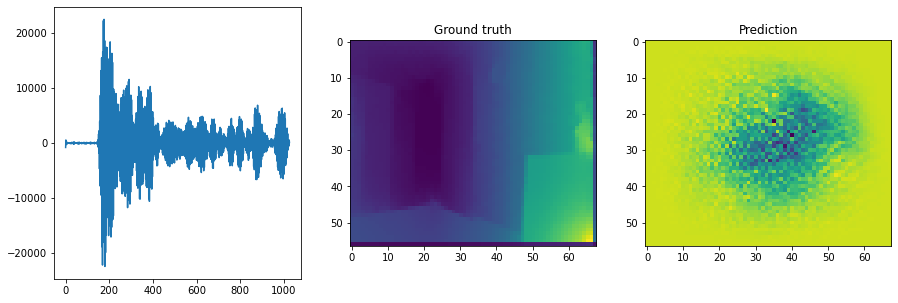

pene


<Figure size 432x288 with 0 Axes>

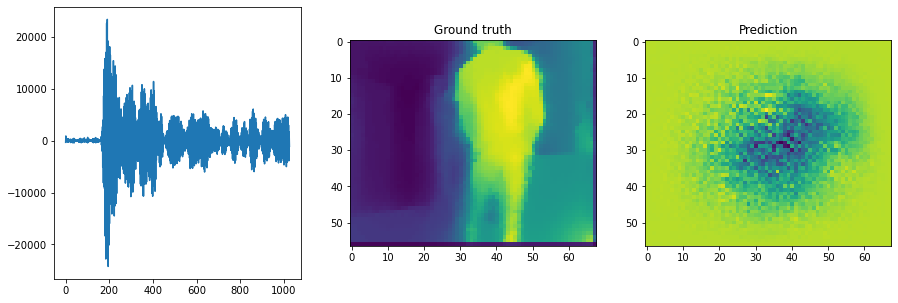

pene


<Figure size 432x288 with 0 Axes>

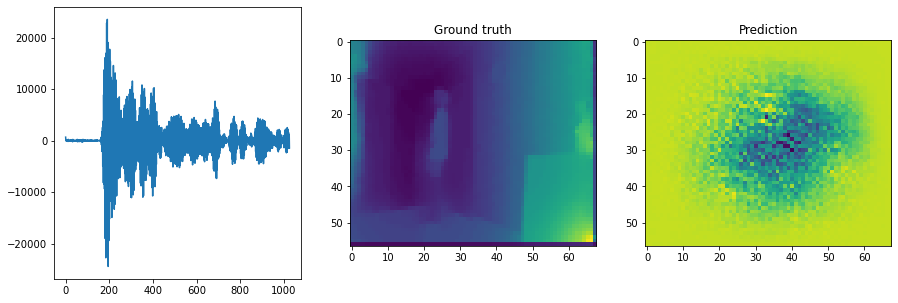

pene


<Figure size 432x288 with 0 Axes>

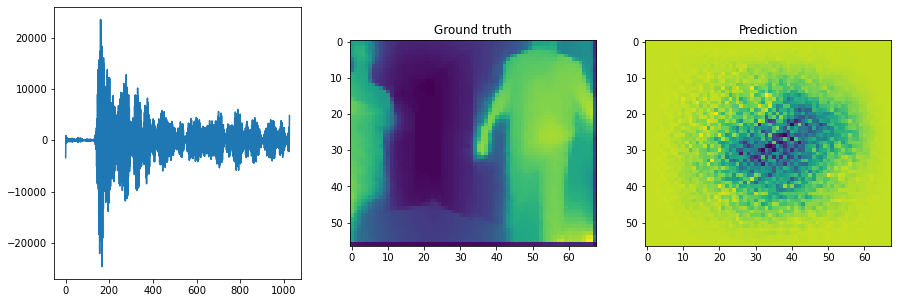

pene


<Figure size 432x288 with 0 Axes>

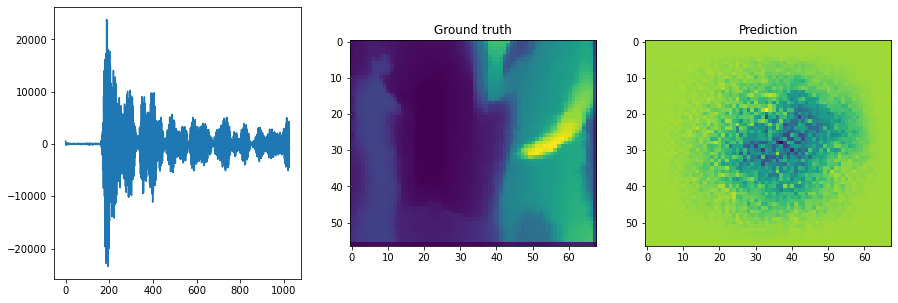

pene


<Figure size 432x288 with 0 Axes>

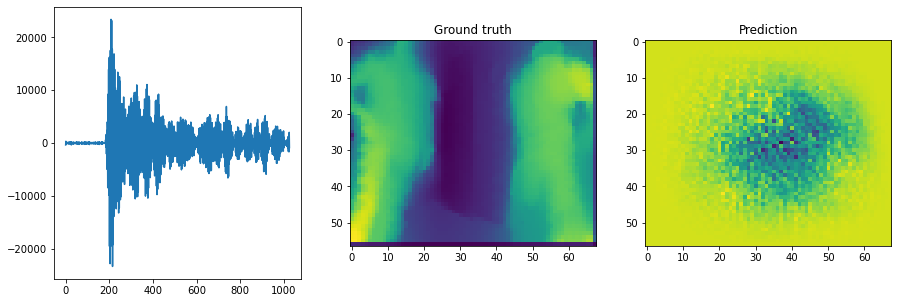

pene


<Figure size 432x288 with 0 Axes>

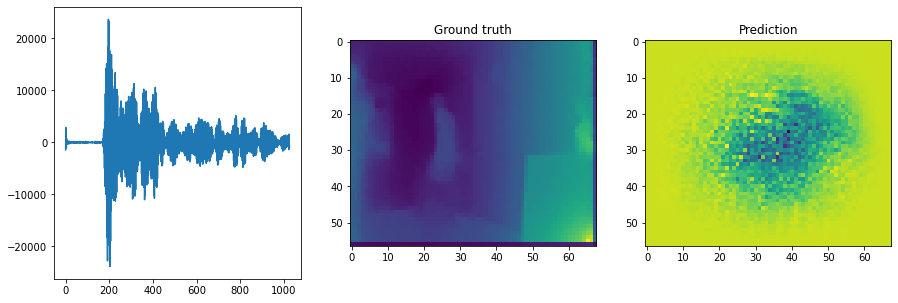

pene


<Figure size 432x288 with 0 Axes>

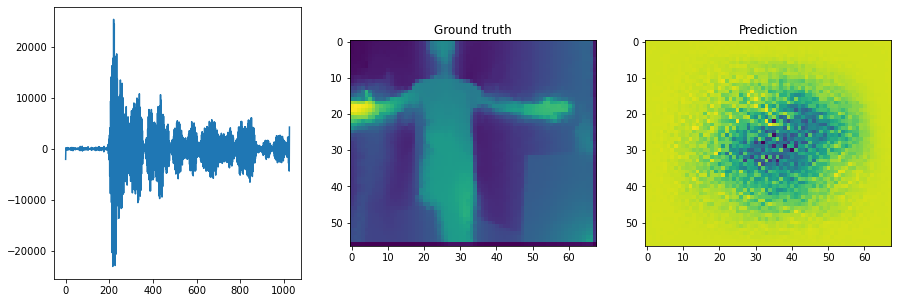

pene


<Figure size 432x288 with 0 Axes>

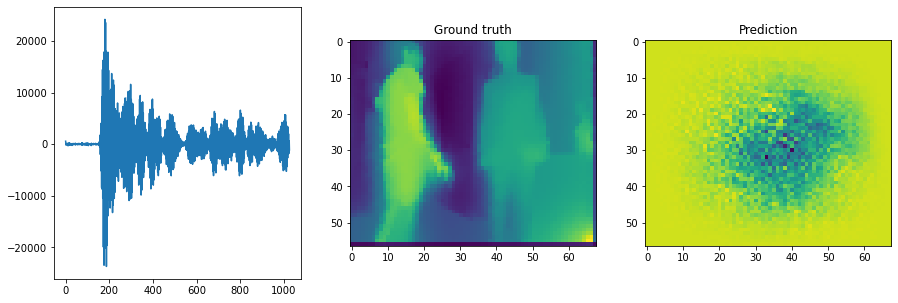

pene


<Figure size 432x288 with 0 Axes>

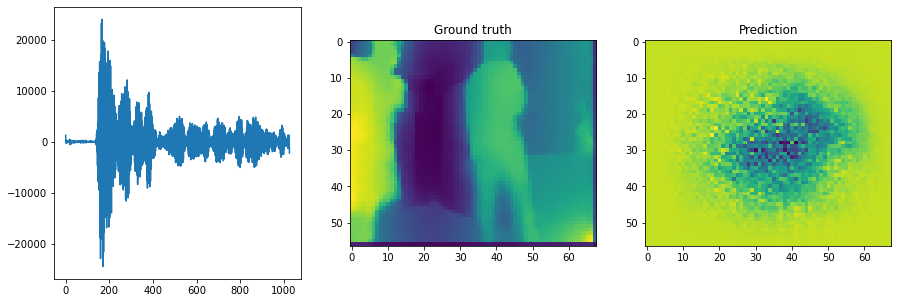

pene


<Figure size 432x288 with 0 Axes>

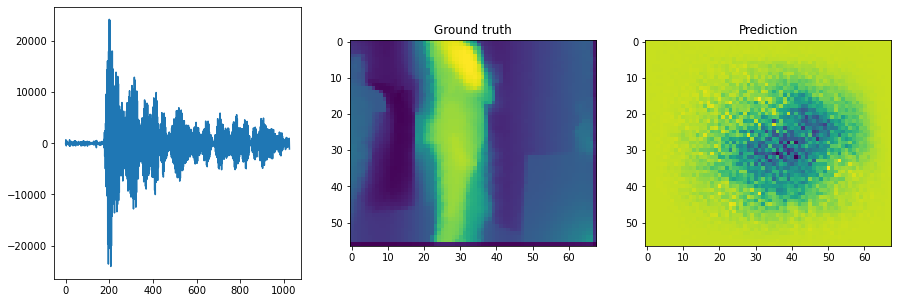

pene


<Figure size 432x288 with 0 Axes>

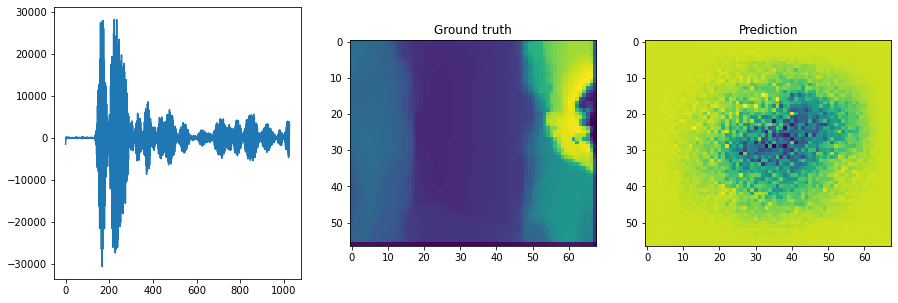

pene


<Figure size 432x288 with 0 Axes>

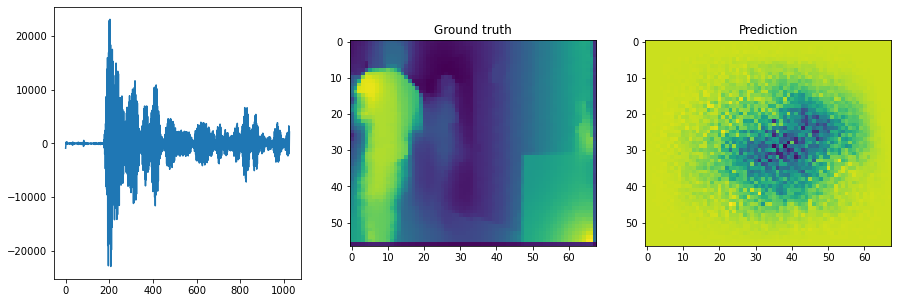

pene


<Figure size 432x288 with 0 Axes>

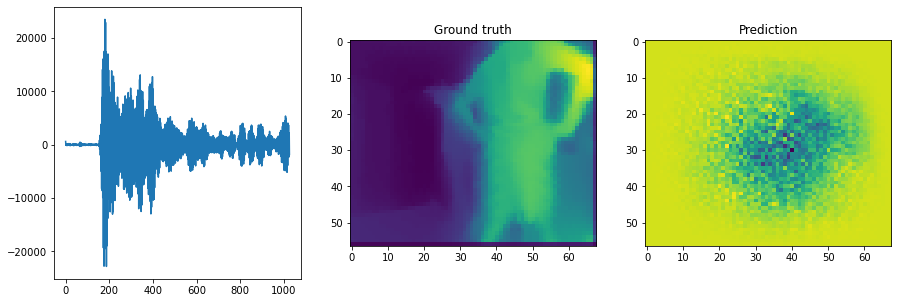

pene


<Figure size 432x288 with 0 Axes>

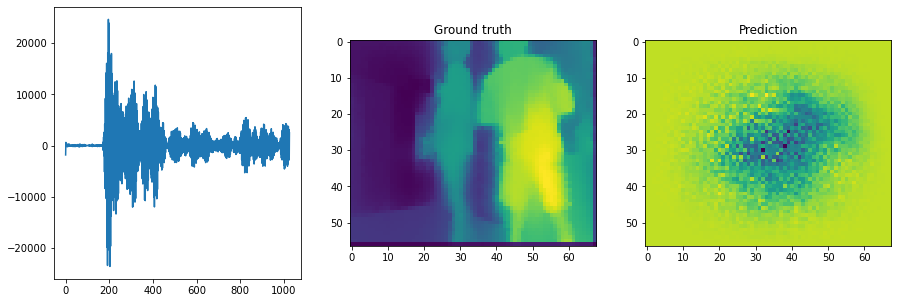

pene


<Figure size 432x288 with 0 Axes>

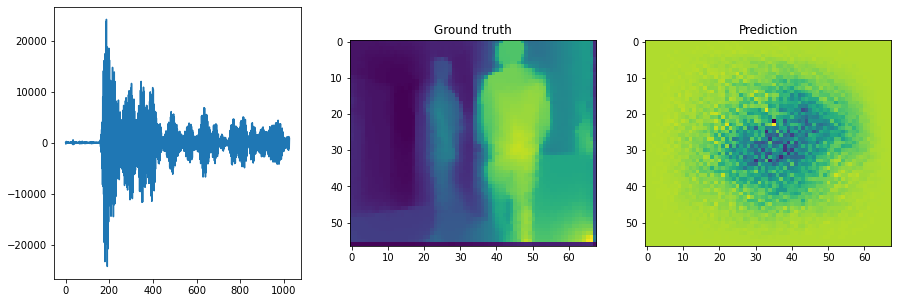

pene


<Figure size 432x288 with 0 Axes>

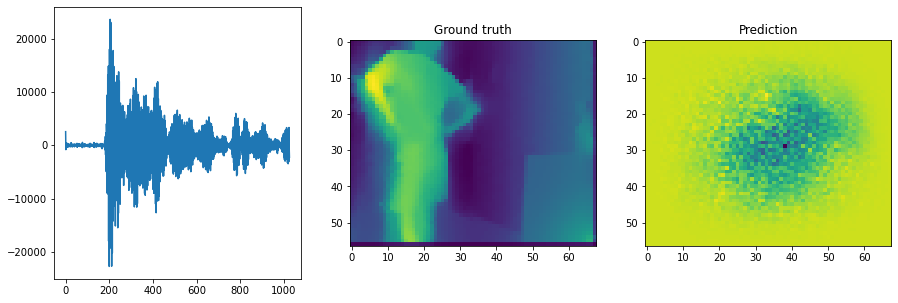



Batch 1 ###############
pene


<Figure size 432x288 with 0 Axes>

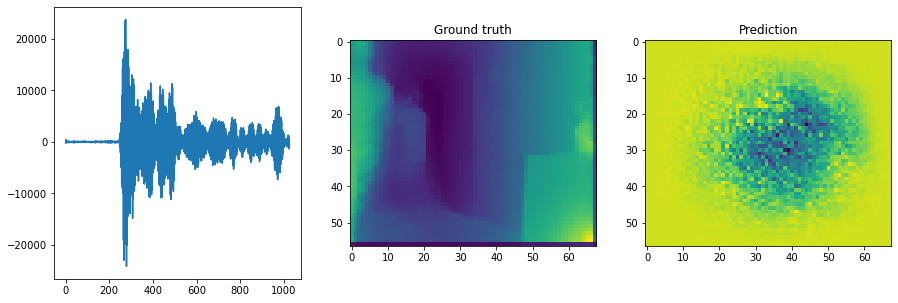

pene


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [11]:
for idx, (audios, images) in enumerate(train_loader):
    audios = audios.to(device)
    pred_ims = model(audios)
    print(f"\n\nBatch {idx} ###############")
    for audio, image, pred_image in zip(audios, images, pred_ims):
        print("pene")
        audio_np = np.array(audio.to('cpu').detach().numpy())
        image_np = np.array(image.to('cpu').detach().numpy())
        pred_image_np = np.array(pred_image.to('cpu').detach().numpy())
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        axs[0].plot(audio_np)
        axs[1].imshow(image_np)
        axs[1].set_title("Ground truth")
        axs[2].imshow(pred_image_np)
        axs[2].set_title("Prediction")
        plt.show()
        plt.clf()
    if idx==0:
        break